# Imports

In [51]:
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Model load

In [26]:
path_qing_cheng = './model/qing_cheng'
path_vallen = './model/vallen'

In [27]:
def get_file_paths(path: str):
    file_paths = []

    for dir_path, _, file_names in os.walk(path):
        file_path = {}
        
        for file_name in file_names:
            
            if file_name.endswith('.h5'):
                file_path['model'] = os.path.join(dir_path, file_name)
                
            elif file_name.endswith('x.npy'):
                file_path['x'] = os.path.join(dir_path, file_name)
                
            elif file_name.endswith('y.npy'):
                file_path['y'] = os.path.join(dir_path, file_name)
                
            elif file_name.endswith('all_results.csv'):
                file_path['all_results'] = os.path.join(dir_path, file_name)
                
        if len(file_path) > 0:
            file_paths.append(file_path)

    return file_paths

In [28]:
paths_qing_cheng = get_file_paths(path_qing_cheng)
paths_vallen = get_file_paths(path_vallen)

In [29]:
def load_model_result(path_dict: dict):
    model = load_model(path_dict['model'])
    x = np.load(path_dict['x'])
    y = np.load(path_dict['y'])
    
    y_predicted = model.predict(x)
    y_predicted_classes = np.argmax(y_predicted, axis=1)
    
    all_results = pd.read_csv(path_dict['all_results'])
    
    return {
        'model': model, 
        'x': x, 
        'y': y, 
        'y_predicted': y_predicted, 
        'y_predicted_classes': y_predicted_classes,
        'all_results': all_results,
    }

In [30]:
qing_cheng_models = [load_model_result(path) for path in paths_qing_cheng]
vallen_models = [load_model_result(path) for path in paths_vallen]

282/282 [==============================] - 2s 8ms/step


# Confusion matrix

In [31]:
position_class_label = ['No Leakage', 'Leakage in position 2', 'Leakage in position 3', 'Leakage in position 4']
boolean_class_label = ['No Leakage', 'Leakage']

qing_cheng_model_name = 'Qing-Cheng'
vallen_model_name = 'Vallen'

In [32]:
def plot_confusion_matrix(model_a:dict, model_a_name: str, model_b:dict, model_b_name:str, class_labels: list[str], title:str):
    matrix_a = confusion_matrix(model_a['y'], model_a['y_predicted_classes'])
    matrix_b = confusion_matrix(model_b['y'], model_b['y_predicted_classes'])
    
    matrix_a_percent = matrix_a / matrix_a.sum(axis=1)[:, np.newaxis] * 100
    matrix_b_percent = matrix_b / matrix_b.sum(axis=1)[:, np.newaxis] * 100
    
    matrix_a_df = pd.DataFrame(matrix_a_percent, columns=class_labels, index=class_labels)
    matrix_b_df = pd.DataFrame(matrix_b_percent, columns=class_labels, index=class_labels)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    heatmap_a = sns.heatmap(matrix_a_df, annot=True, cmap='Blues', fmt='.1f', cbar=False, square=True, linewidths=0.5, ax=ax1)
    heatmap_b = sns.heatmap(matrix_b_df, annot=True, cmap='Blues', fmt='.1f', cbar=False, square=True, linewidths=0.5, ax=ax2)
    
    # Rotate x-axis labels by 45 degrees
    heatmap_a.set_xticklabels(heatmap_a.get_xticklabels(), rotation=45, ha='right')
    heatmap_b.set_xticklabels(heatmap_b.get_xticklabels(), rotation=45, ha='right')
    
    ax1.set_title(f'{model_a_name}')
    ax2.set_title(f'{model_b_name}')
    
    plt.suptitle(title, y=1.05)
    
    plt.tight_layout()
    plt.show()

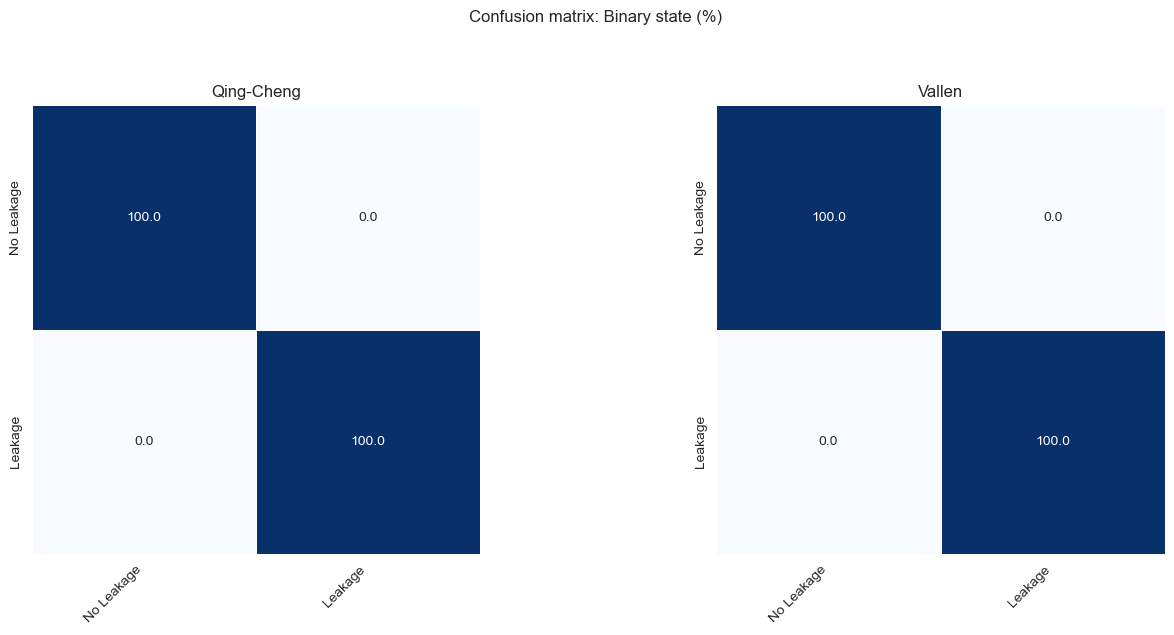

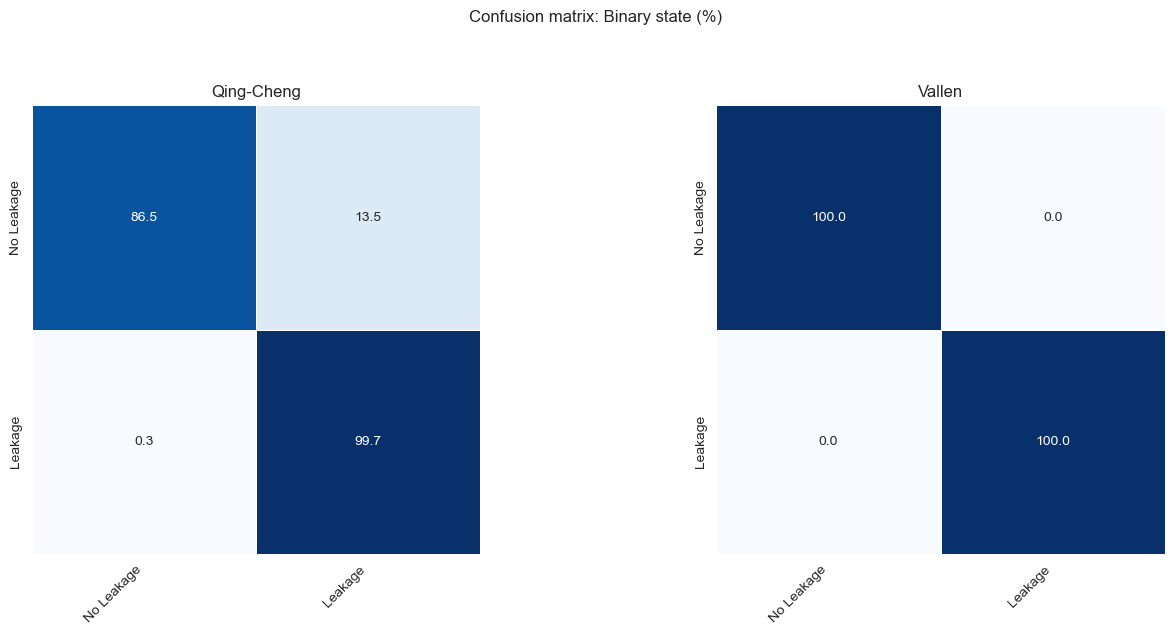

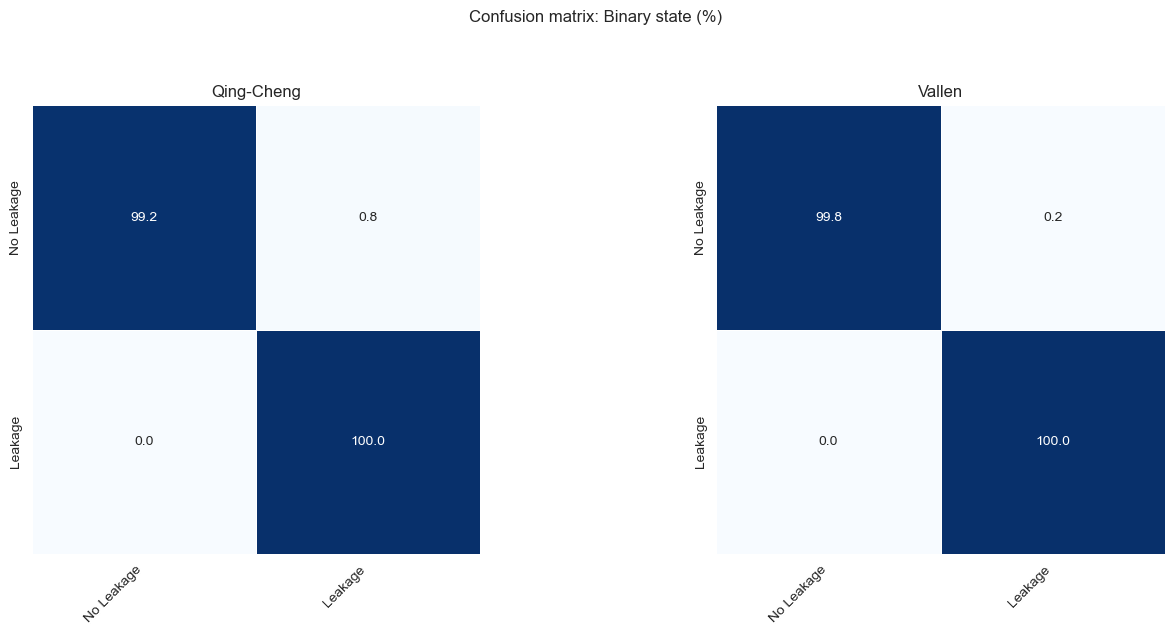

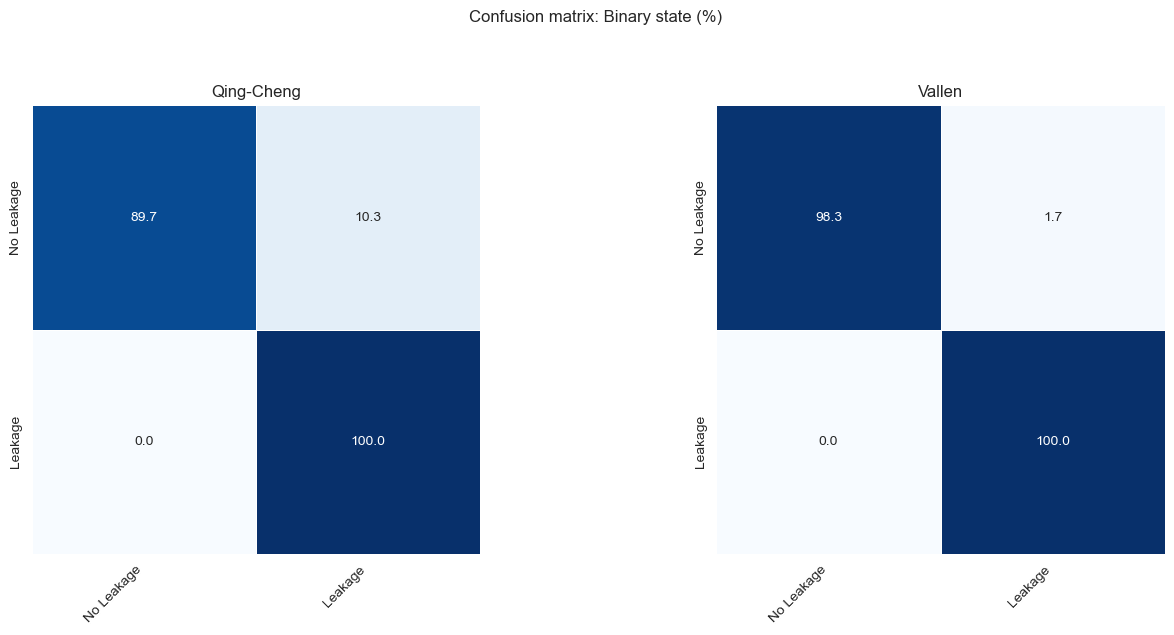

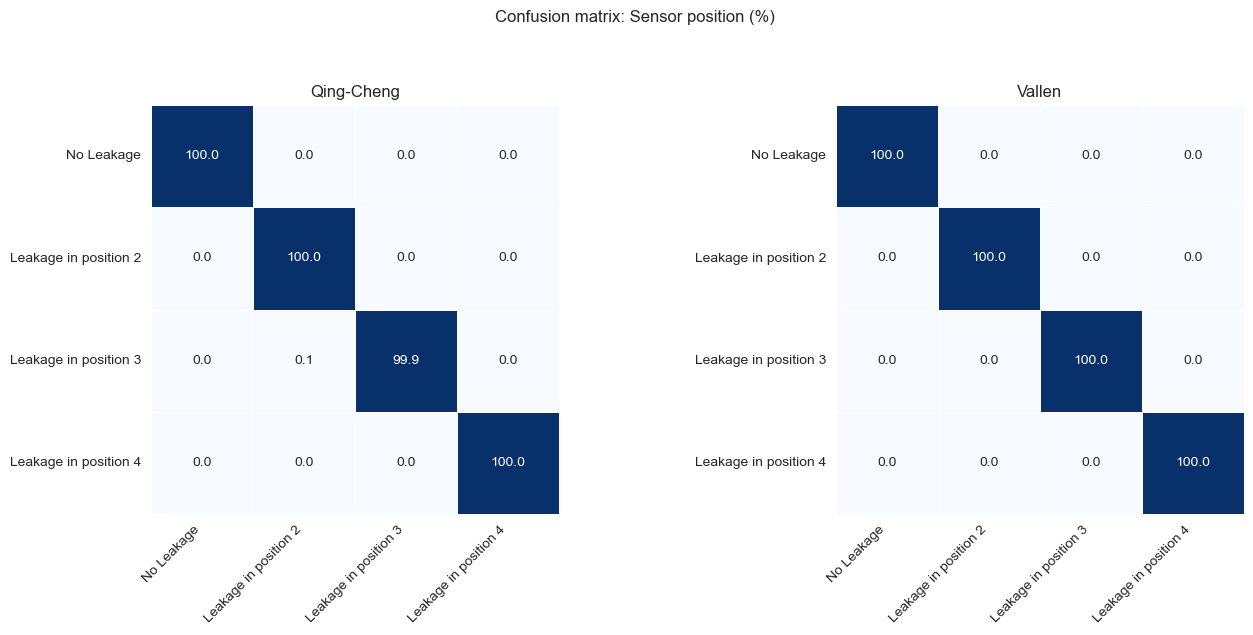

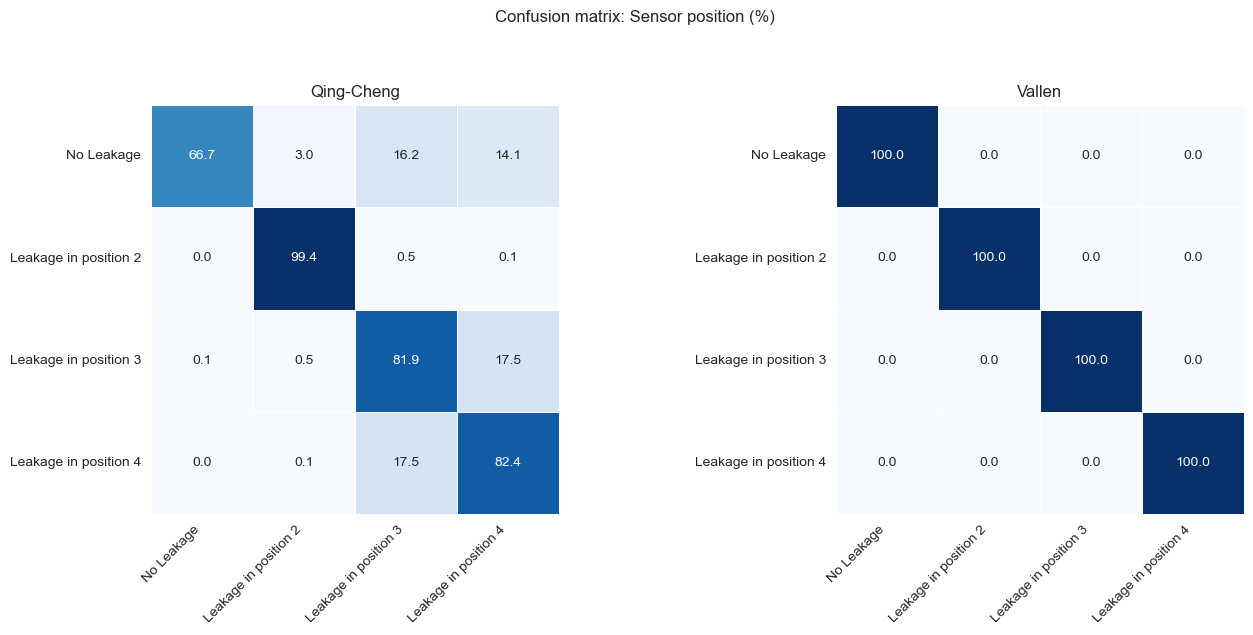

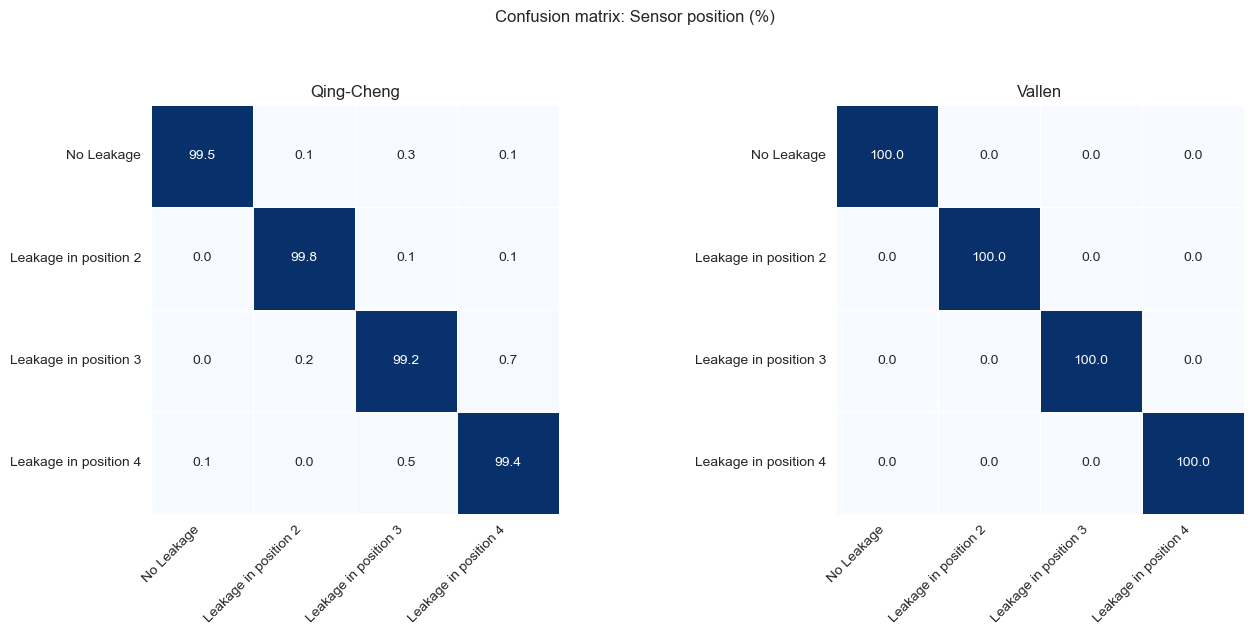

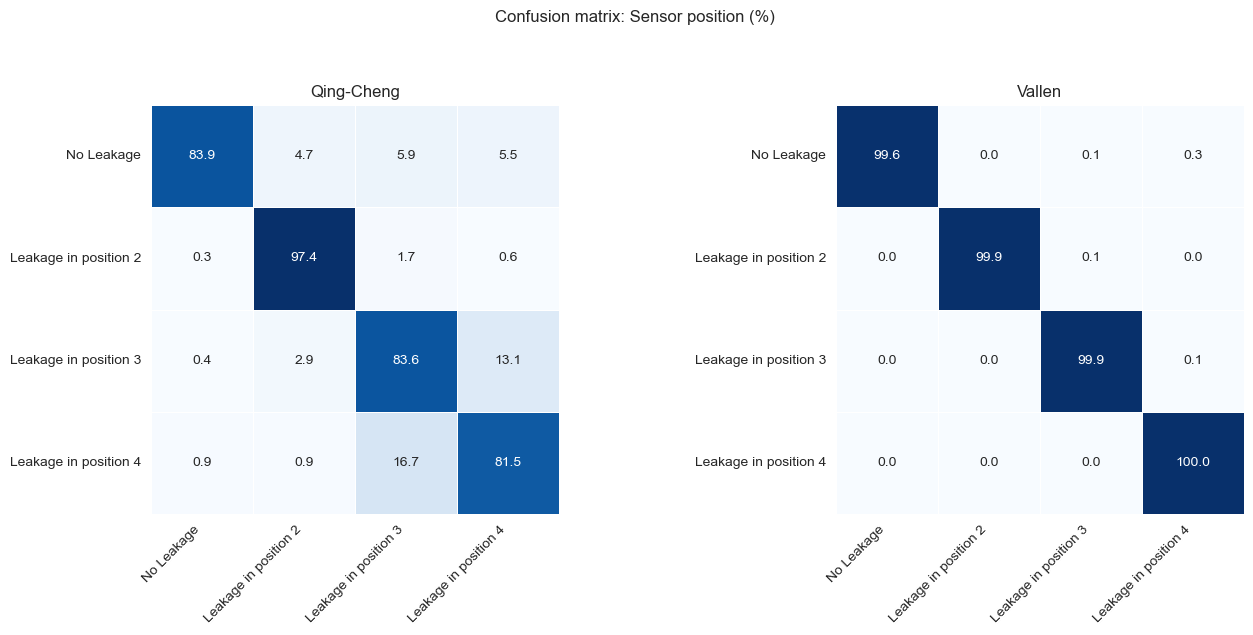

In [33]:
for index in range(len(qing_cheng_models)):
    if index < 4:
        plot_confusion_matrix(
            qing_cheng_models[index], 
            qing_cheng_model_name, 
            vallen_models[index], 
            vallen_model_name, 
            boolean_class_label, 
            'Confusion matrix: Binary state (%)'
        )
    
    else:
        plot_confusion_matrix(
            qing_cheng_models[index], 
            qing_cheng_model_name, 
            vallen_models[index], 
            vallen_model_name, 
            position_class_label,
            'Confusion matrix: Sensor position (%)'
        )

# Linear Regression

In [34]:
def plot_linear_regression(model_a:dict, model_a_name: str, model_b:dict, model_b_name:str, title:str):
    matrix_a = confusion_matrix(model_a['y'], model_a['y_predicted_classes'])
    matrix_b = confusion_matrix(model_b['y'], model_b['y_predicted_classes'])
    
    matrix_a_percent = matrix_a / matrix_a.sum(axis=1)[:, np.newaxis] * 100
    matrix_b_percent = matrix_b / matrix_b.sum(axis=1)[:, np.newaxis] * 100
    
    x = [25, 60, 95]
    
    y_a = np.diag(matrix_a_percent)[1:]
    y_b = np.diag(matrix_b_percent)[1:]
    
    coefficient_a = np.polyfit(x, y_a, 1)
    coefficient_b = np.polyfit(x, y_b, 1)
    
    polynomial_a = np.poly1d(coefficient_a)
    polynomial_b = np.poly1d(coefficient_b)
    
    y_fit_a = polynomial_a(x)
    y_fit_b = polynomial_b(x)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    ax1.set_ylim(78, 101)
    ax2.set_ylim(78, 101)
    
    ax1.plot(x, y_a, marker='o')
    ax1.plot(x, y_fit_a, color='#3498db', label='Curva Ajustada (Grau 2)', alpha=0.5)
    
    ax2.plot(x, y_b, marker='o')
    ax2.plot(x, y_fit_b, color='#3498db', label='Curva Ajustada (Grau 2)', alpha=0.5)
    
    ax1.set_title(f'{model_a_name}')
    ax2.set_title(f'{model_b_name}')
    
    plt.suptitle(title, y=1.05)
    
    plt.tight_layout()
    plt.show()

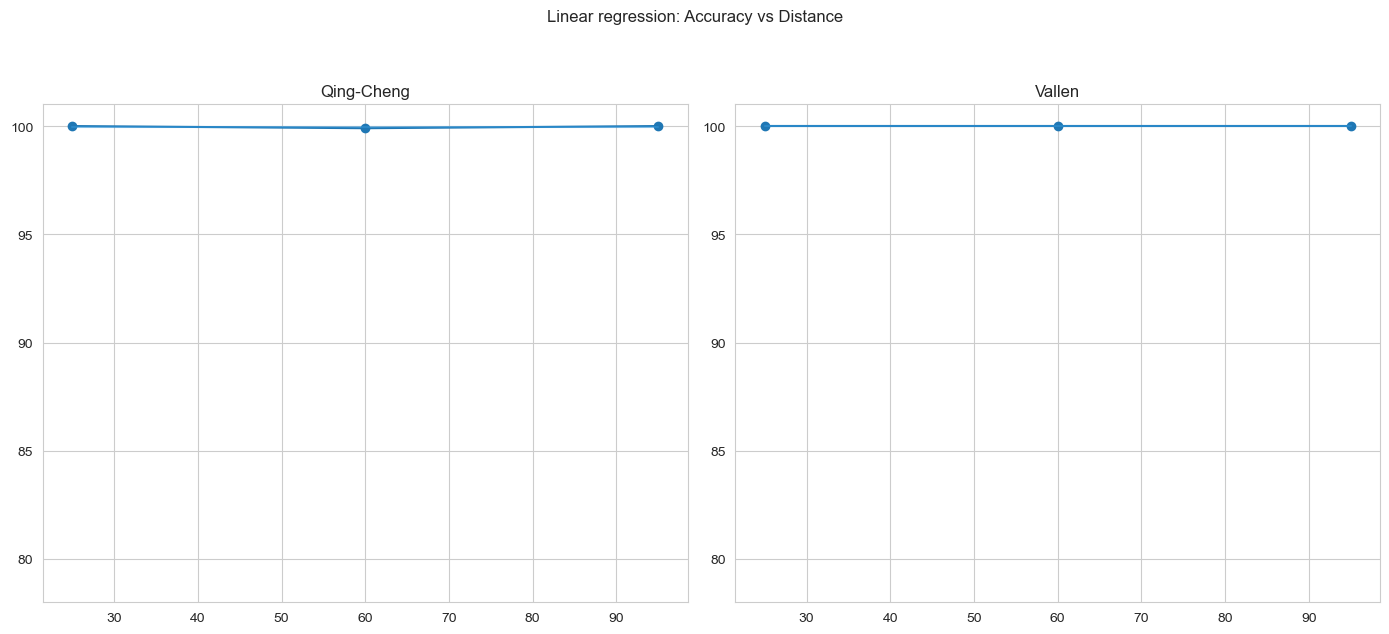

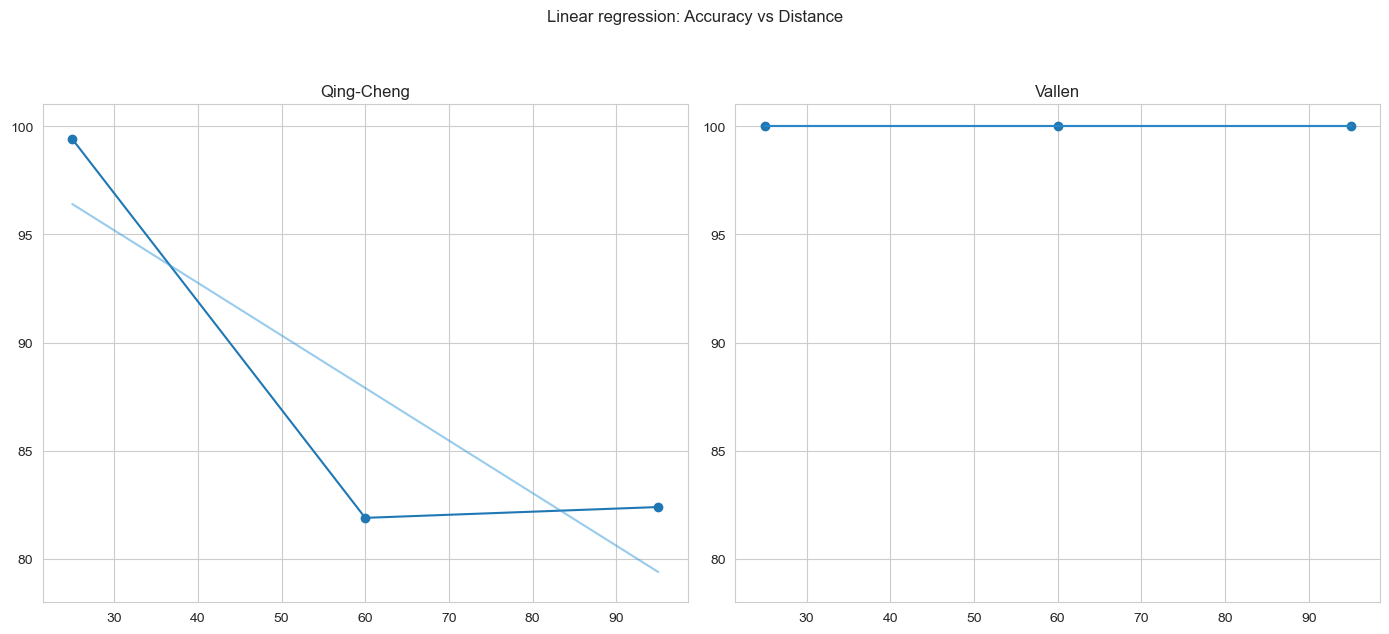

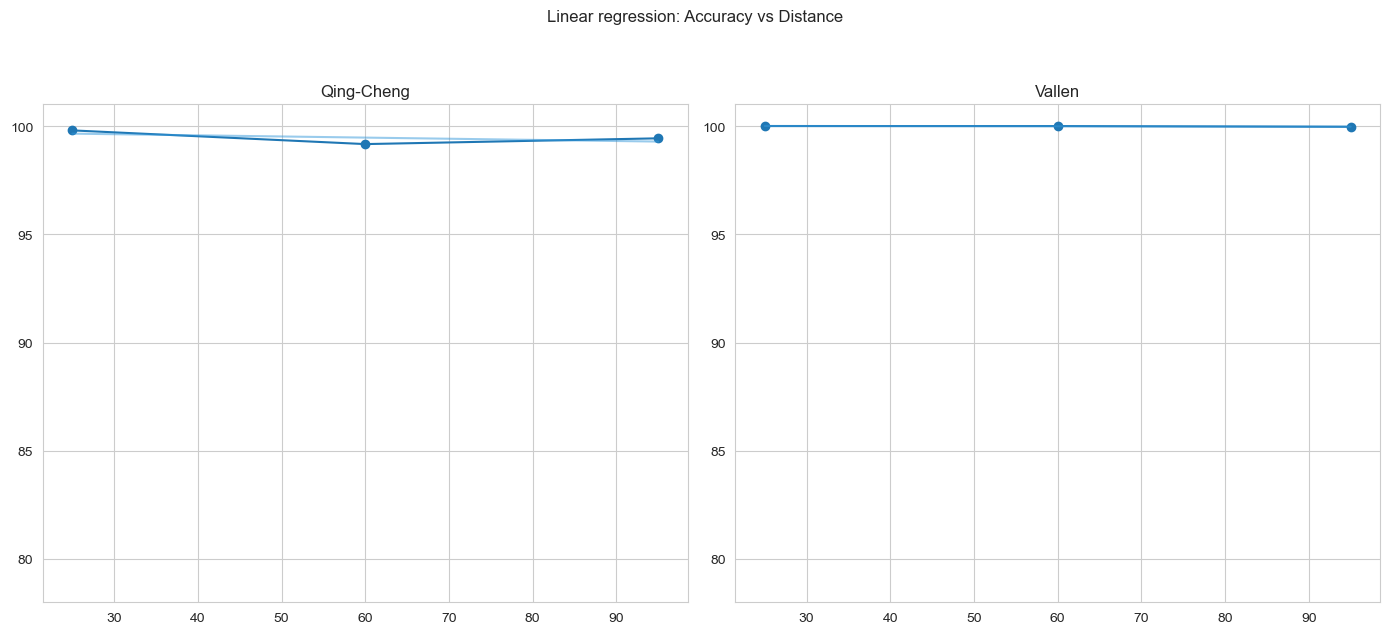

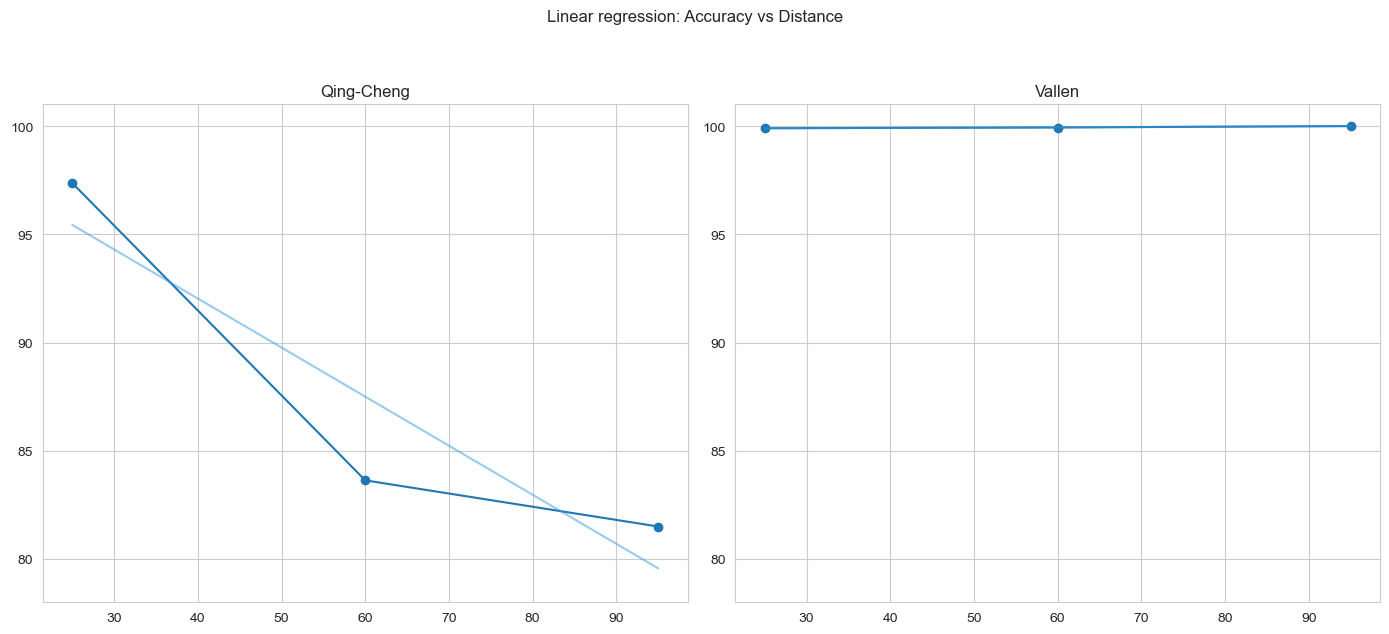

In [35]:
for index in range(4, 8):
    plot_linear_regression(
        qing_cheng_models[index],
        qing_cheng_model_name,
        vallen_models[index],
        vallen_model_name,
        'Linear regression: Accuracy vs Distance'
    )

# Acurácia de validação

In [36]:
def process_scores (scores: list):
    transposed_scores = list(zip(*scores))
    
    return [np.mean(score) for score in transposed_scores]

In [37]:
def process_fold_results (df: pd.DataFrame, model_name):
    new_df = df.copy()
    
    fold_results_df = new_df['Fold Results (accuracy, precision, recall, f1)'].apply(lambda row: eval(row))
    
    new_df.drop('Fold Results (accuracy, precision, recall, f1)',  axis=1, inplace=True)
    
    results_means_df = fold_results_df.apply(process_scores)
    
    new_df['accuracy'] = results_means_df.apply(lambda row: row[0])
    new_df['precision'] = results_means_df.apply(lambda row: row[1])
    new_df['recall'] = results_means_df.apply(lambda row: row[2])
    new_df['f1'] = results_means_df.apply(lambda row: row[3])
                                          
    new_df['model'] = new_df.apply(lambda row: f"{model_name}({ row['num_units'] },{ row['batch_size'] },{ row['epochs'] },{ row['drop_out'] })", axis=1)
    
    return new_df
    

In [38]:
def process_model_results(model_dict: dict, model_name: str):    
    column_dict = {'Num Units': 'num_units', 'Batch Size': 'batch_size', 'Epochs': 'epochs', 'Dense Activation': 'dense_activation', 'drop': 'drop_out'}
    
    model_dict['all_results'] = model_dict['all_results'].rename(column_dict, axis=1)
    
    model_dict['all_results'] = process_fold_results(model_dict['all_results'], model_name)
    
    return

In [39]:
for model in qing_cheng_models:
    process_model_results(model, qing_cheng_model_name)
    
for model in vallen_models:
    process_model_results(model, vallen_model_name)

In [74]:
def plot_all_models_by_metric(model_a: pd.DataFrame, model_b: pd.DataFrame, metric: str='accuracy'):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))

    sns.barplot(x='accuracy', y='model', data=model_a.sort_values(metric, ascending=False), ax=ax1)
    sns.barplot(x='accuracy', y='model', data=model_b.sort_values(metric, ascending=False), ax=ax2)
    
    ax1.set_xticks(np.arange(0, 1.1, 0.1))
    ax2.set_xticks(np.arange(0, 1.1, 0.1))
    
    ax1.set_xlim(0, 1.05)
    ax2.set_xlim(0, 1.05)
    
    plt.show()
    

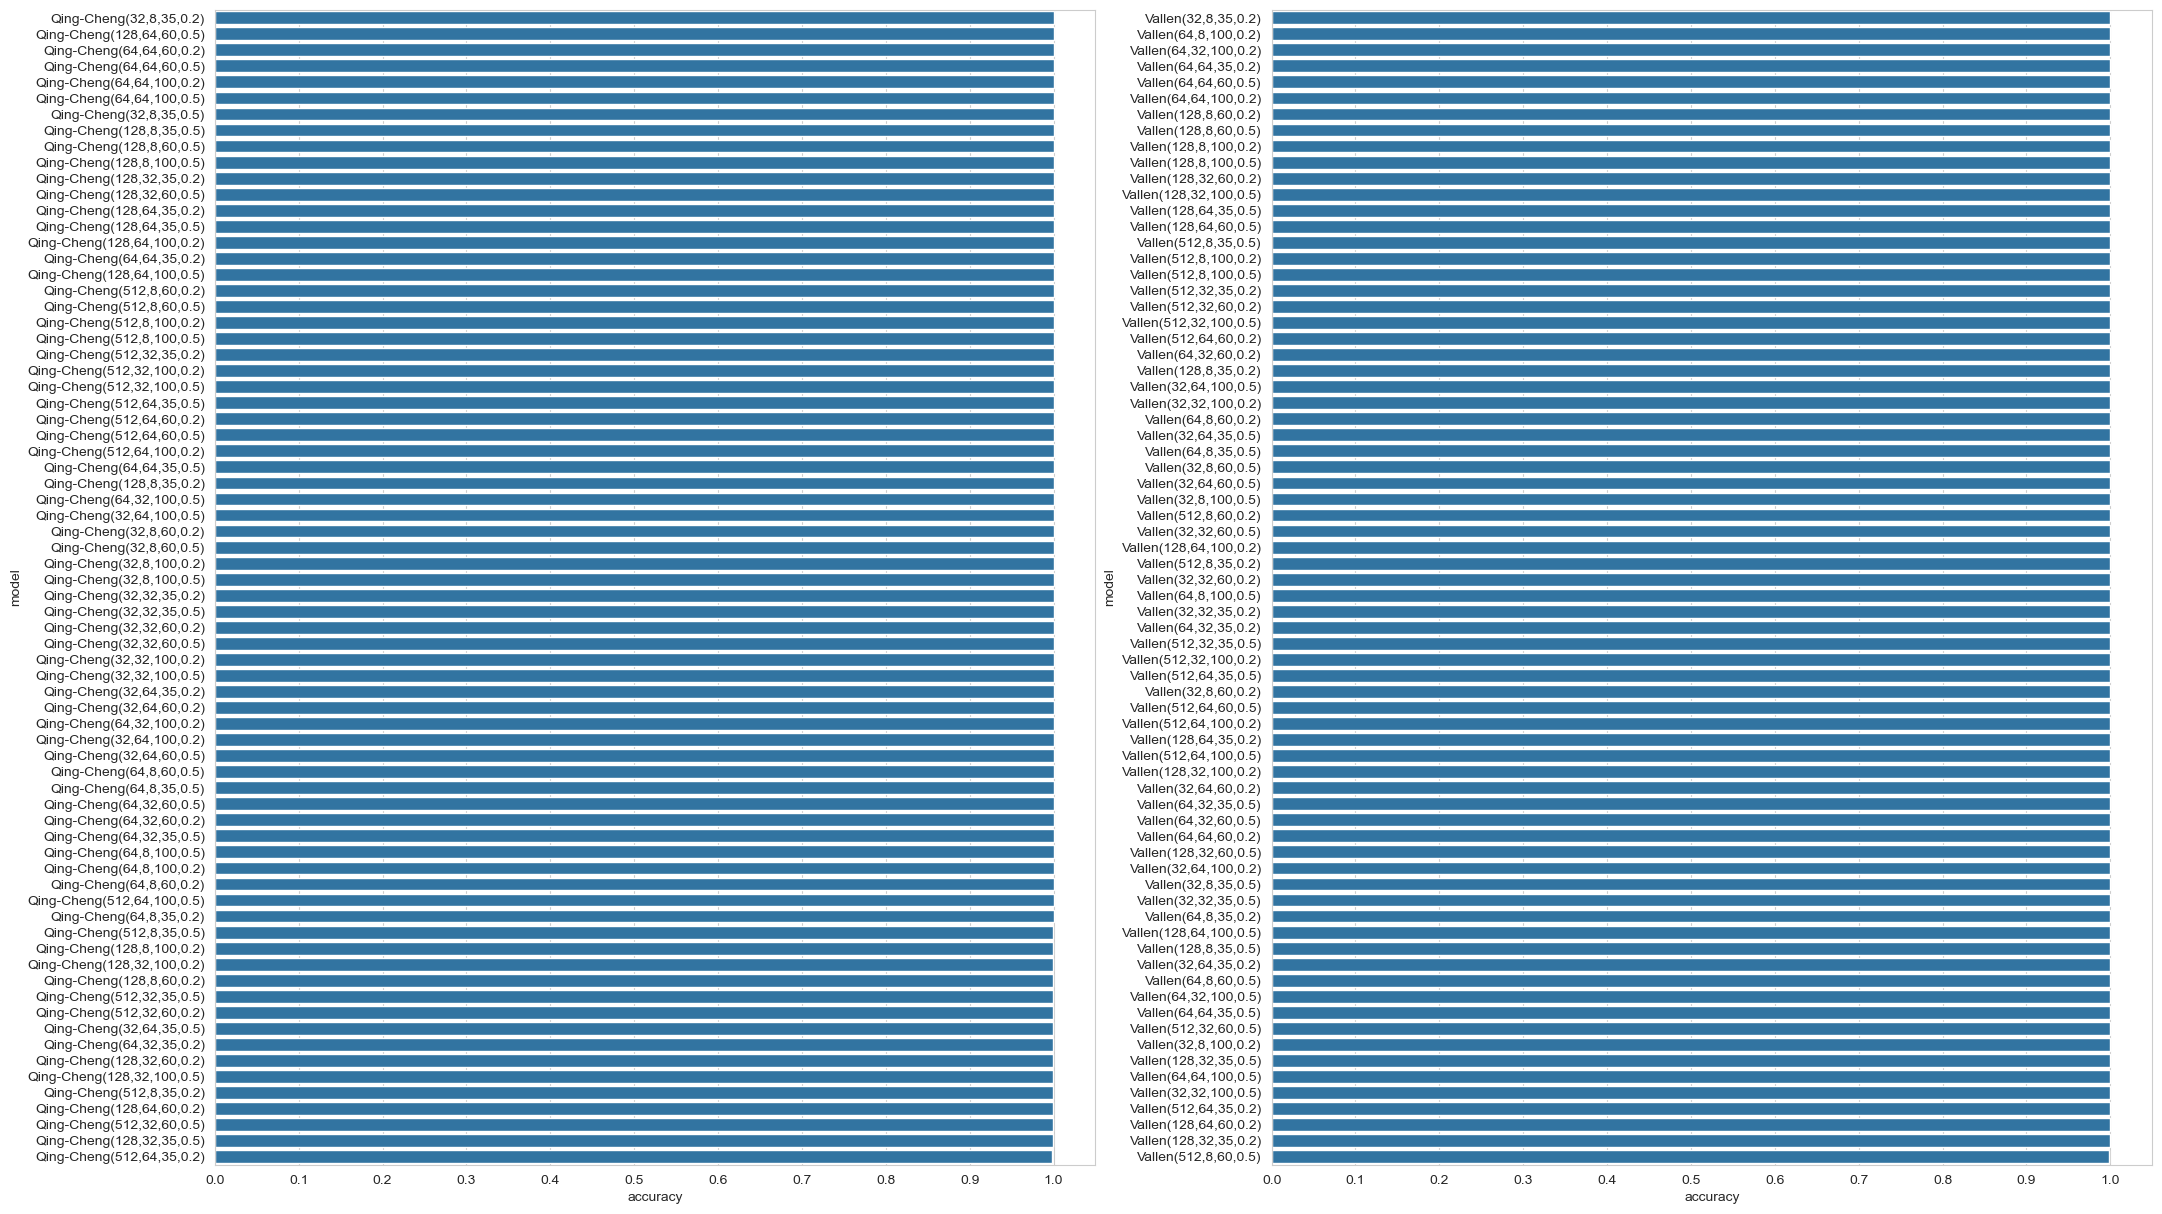

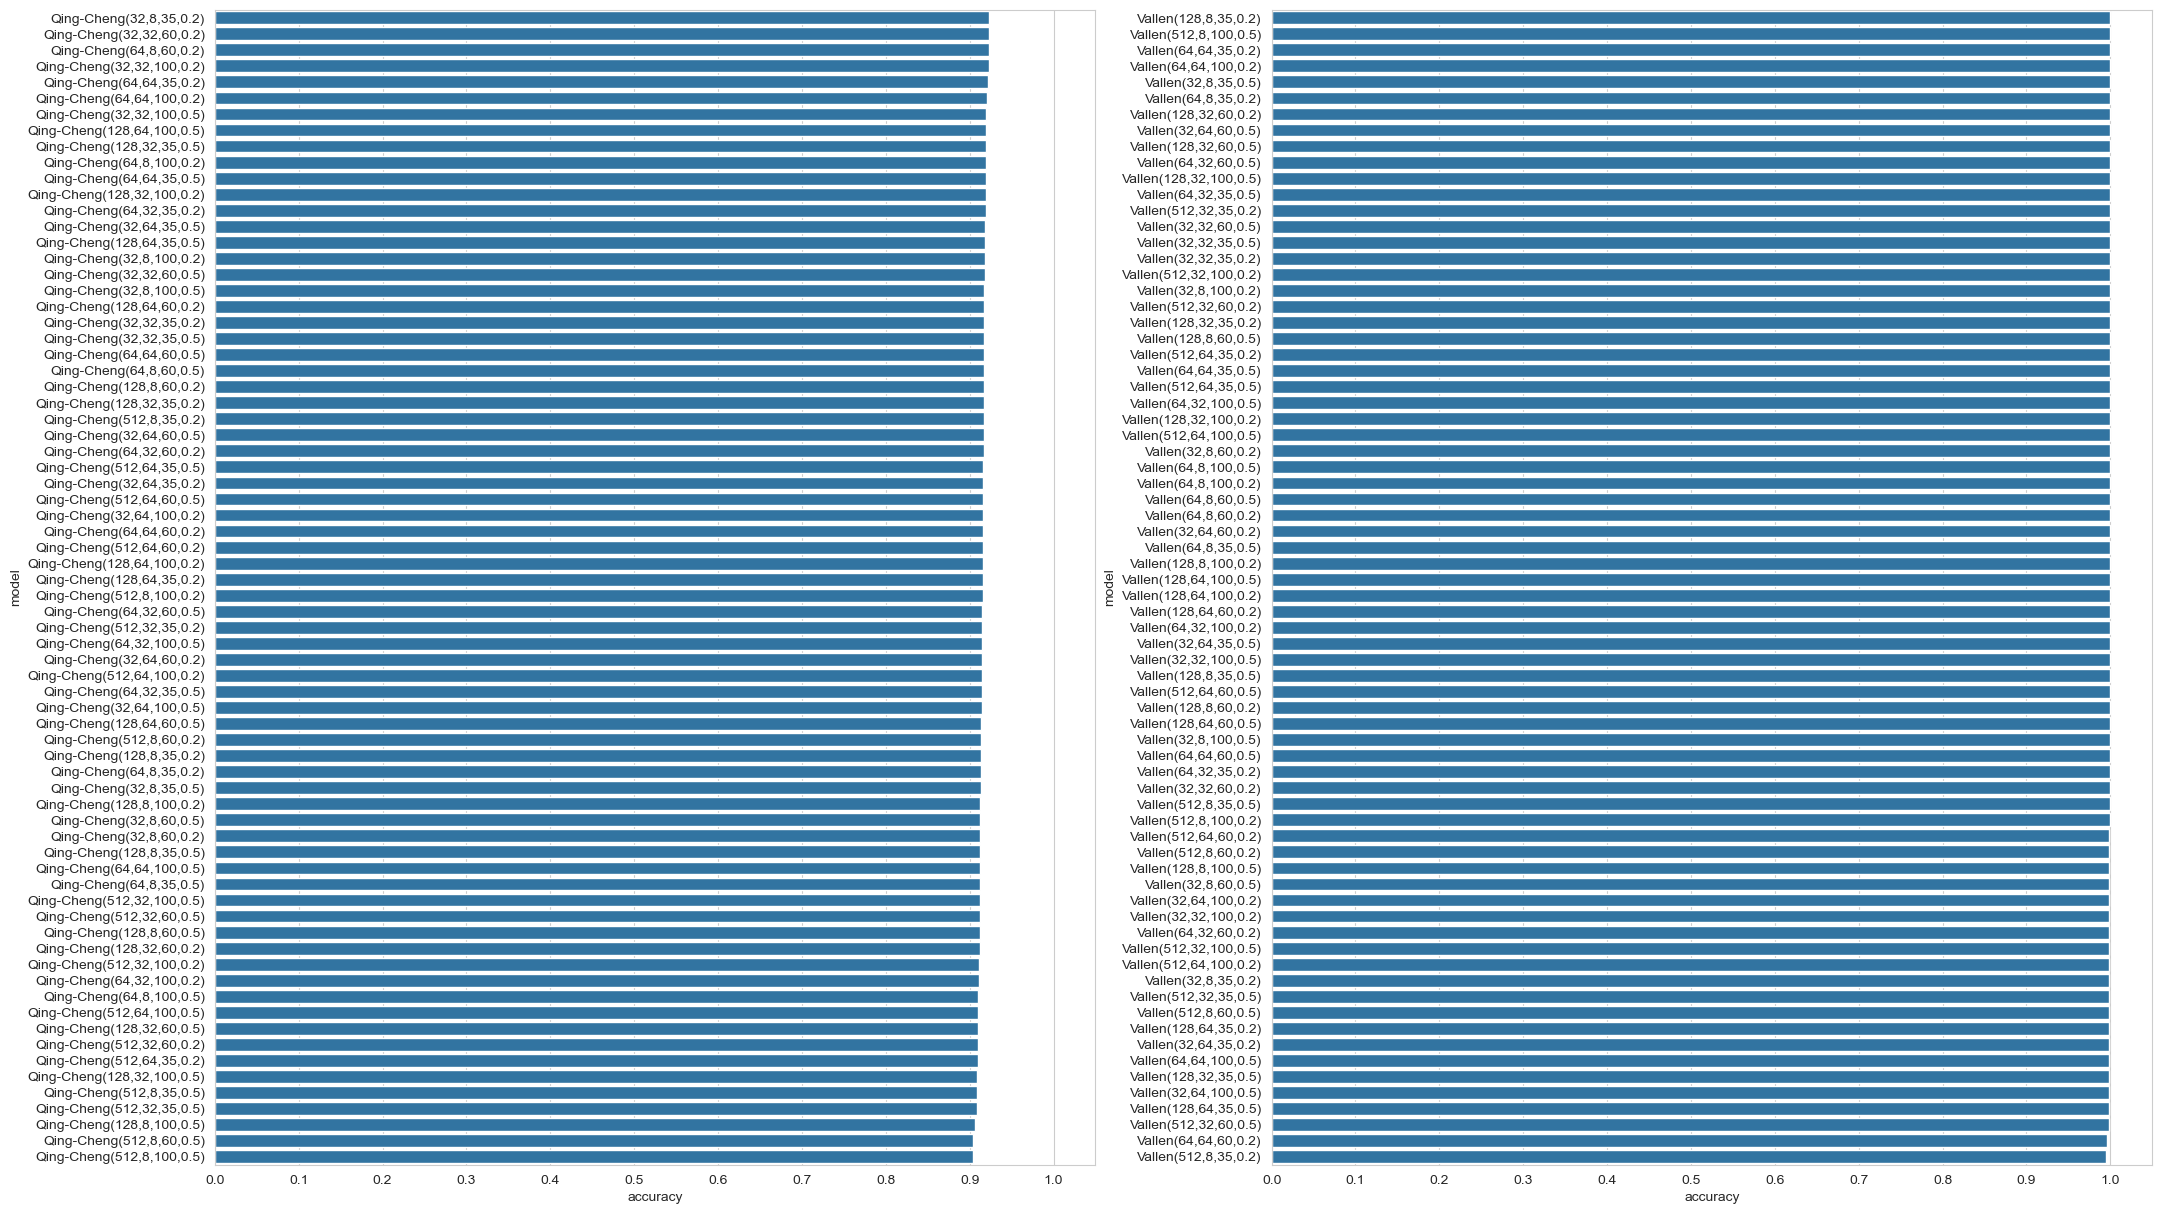

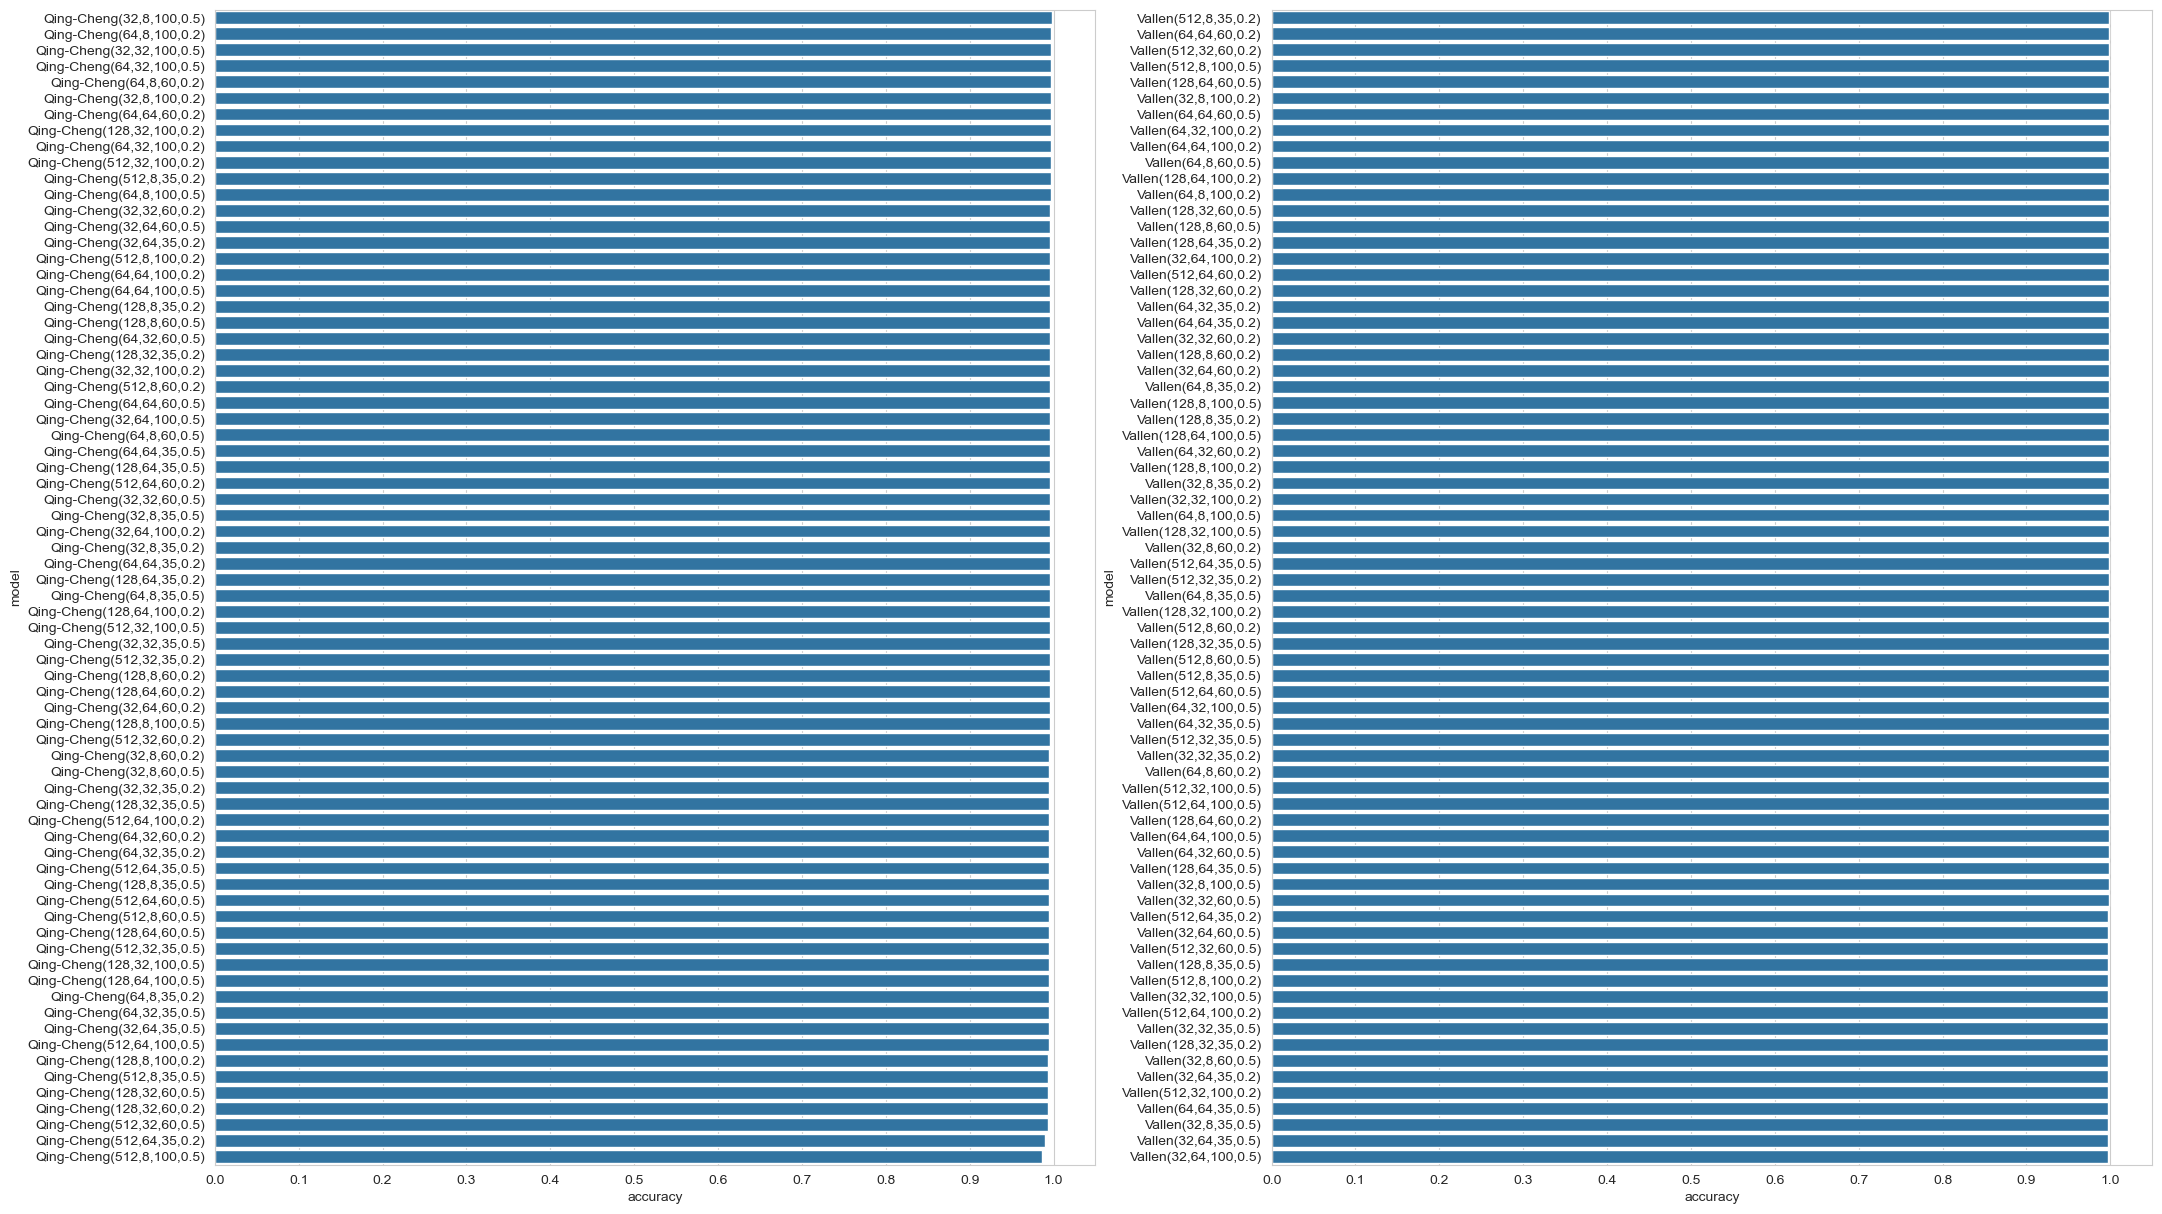

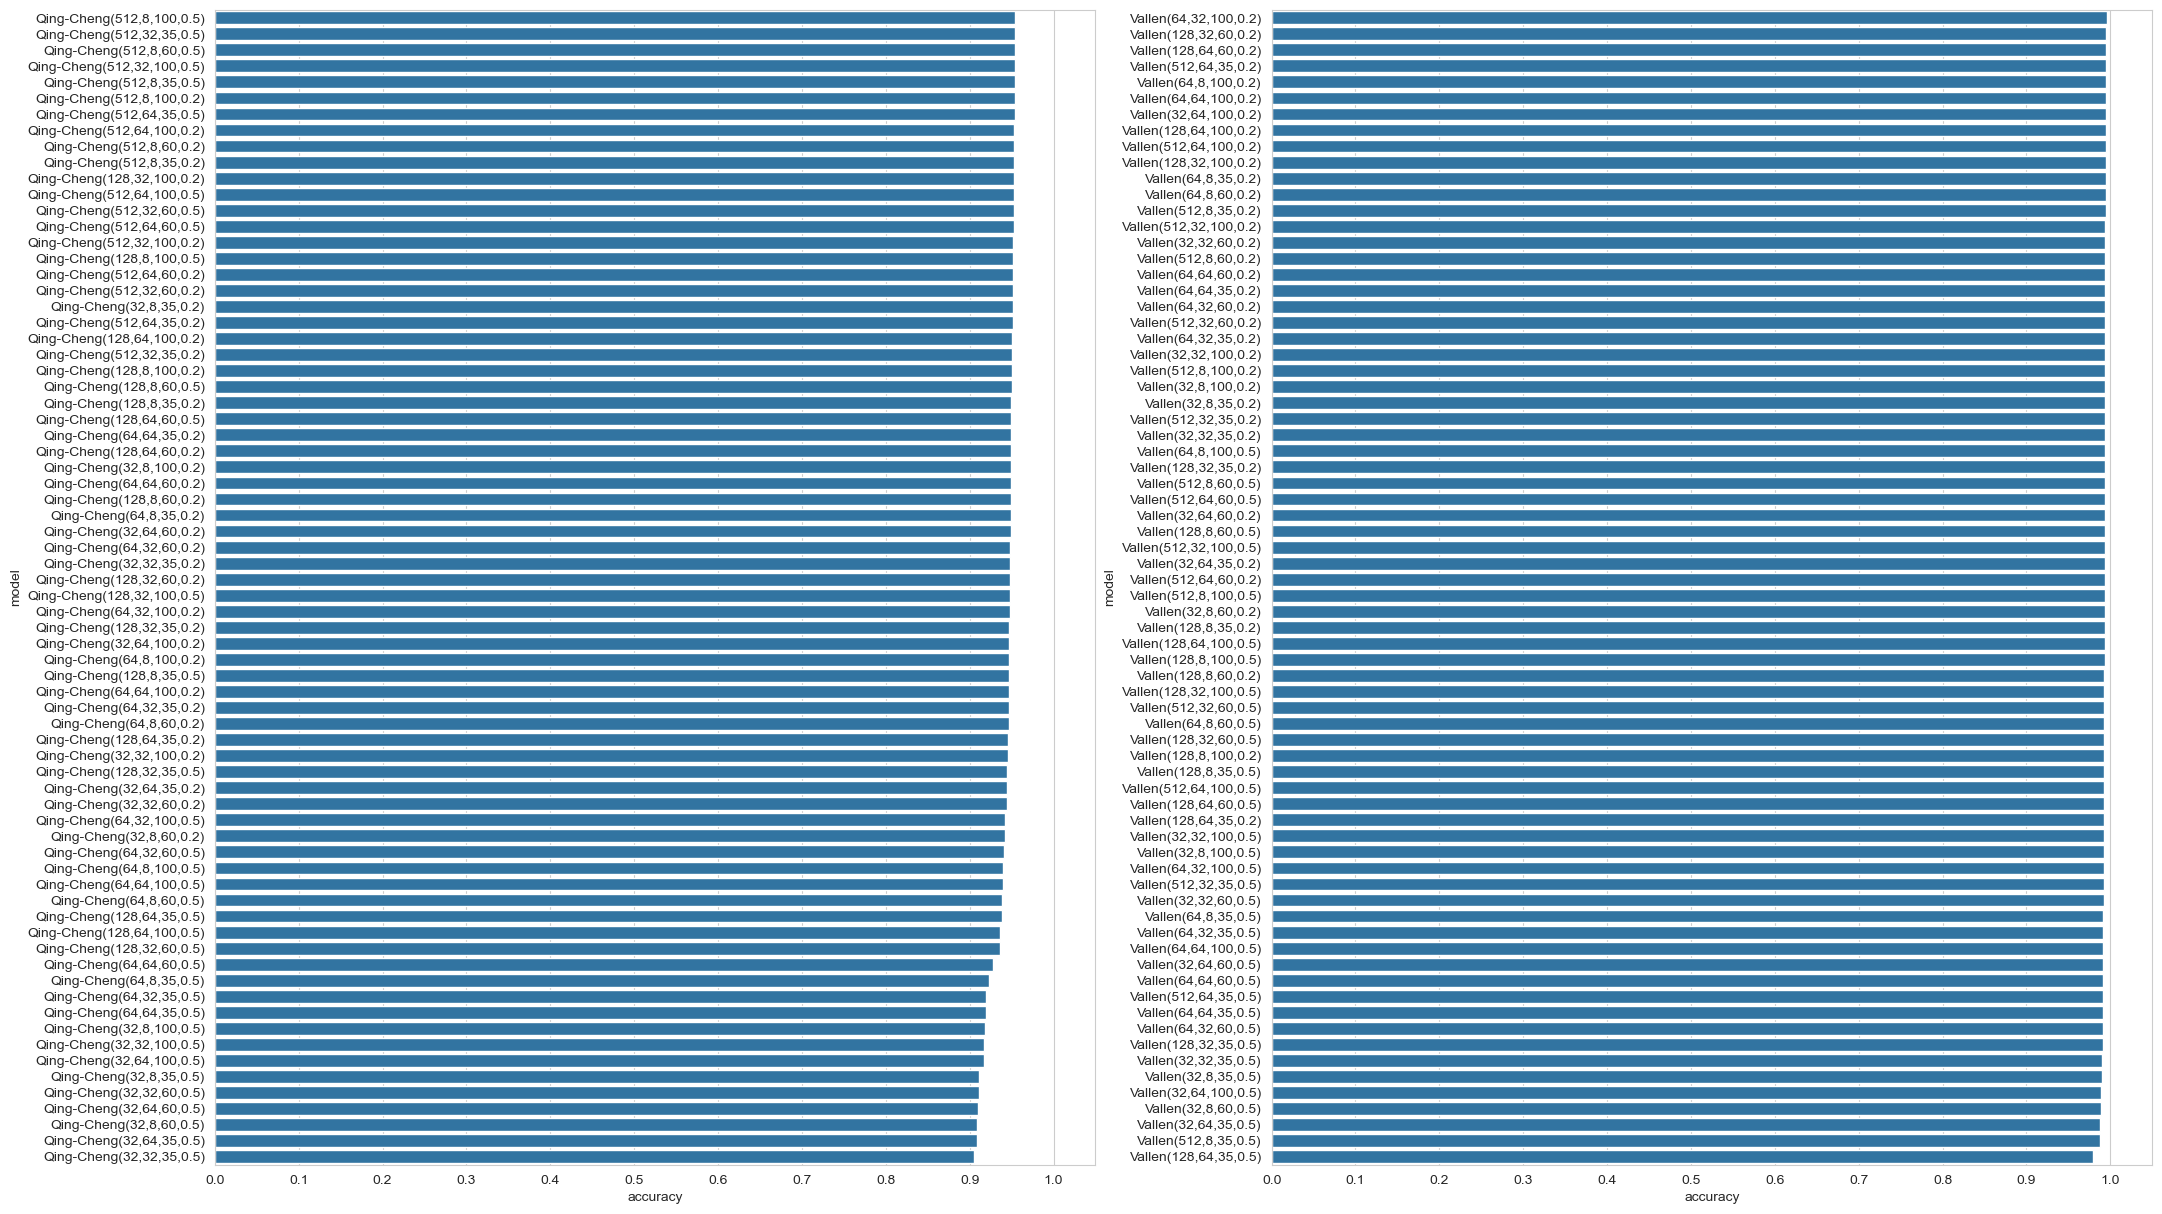

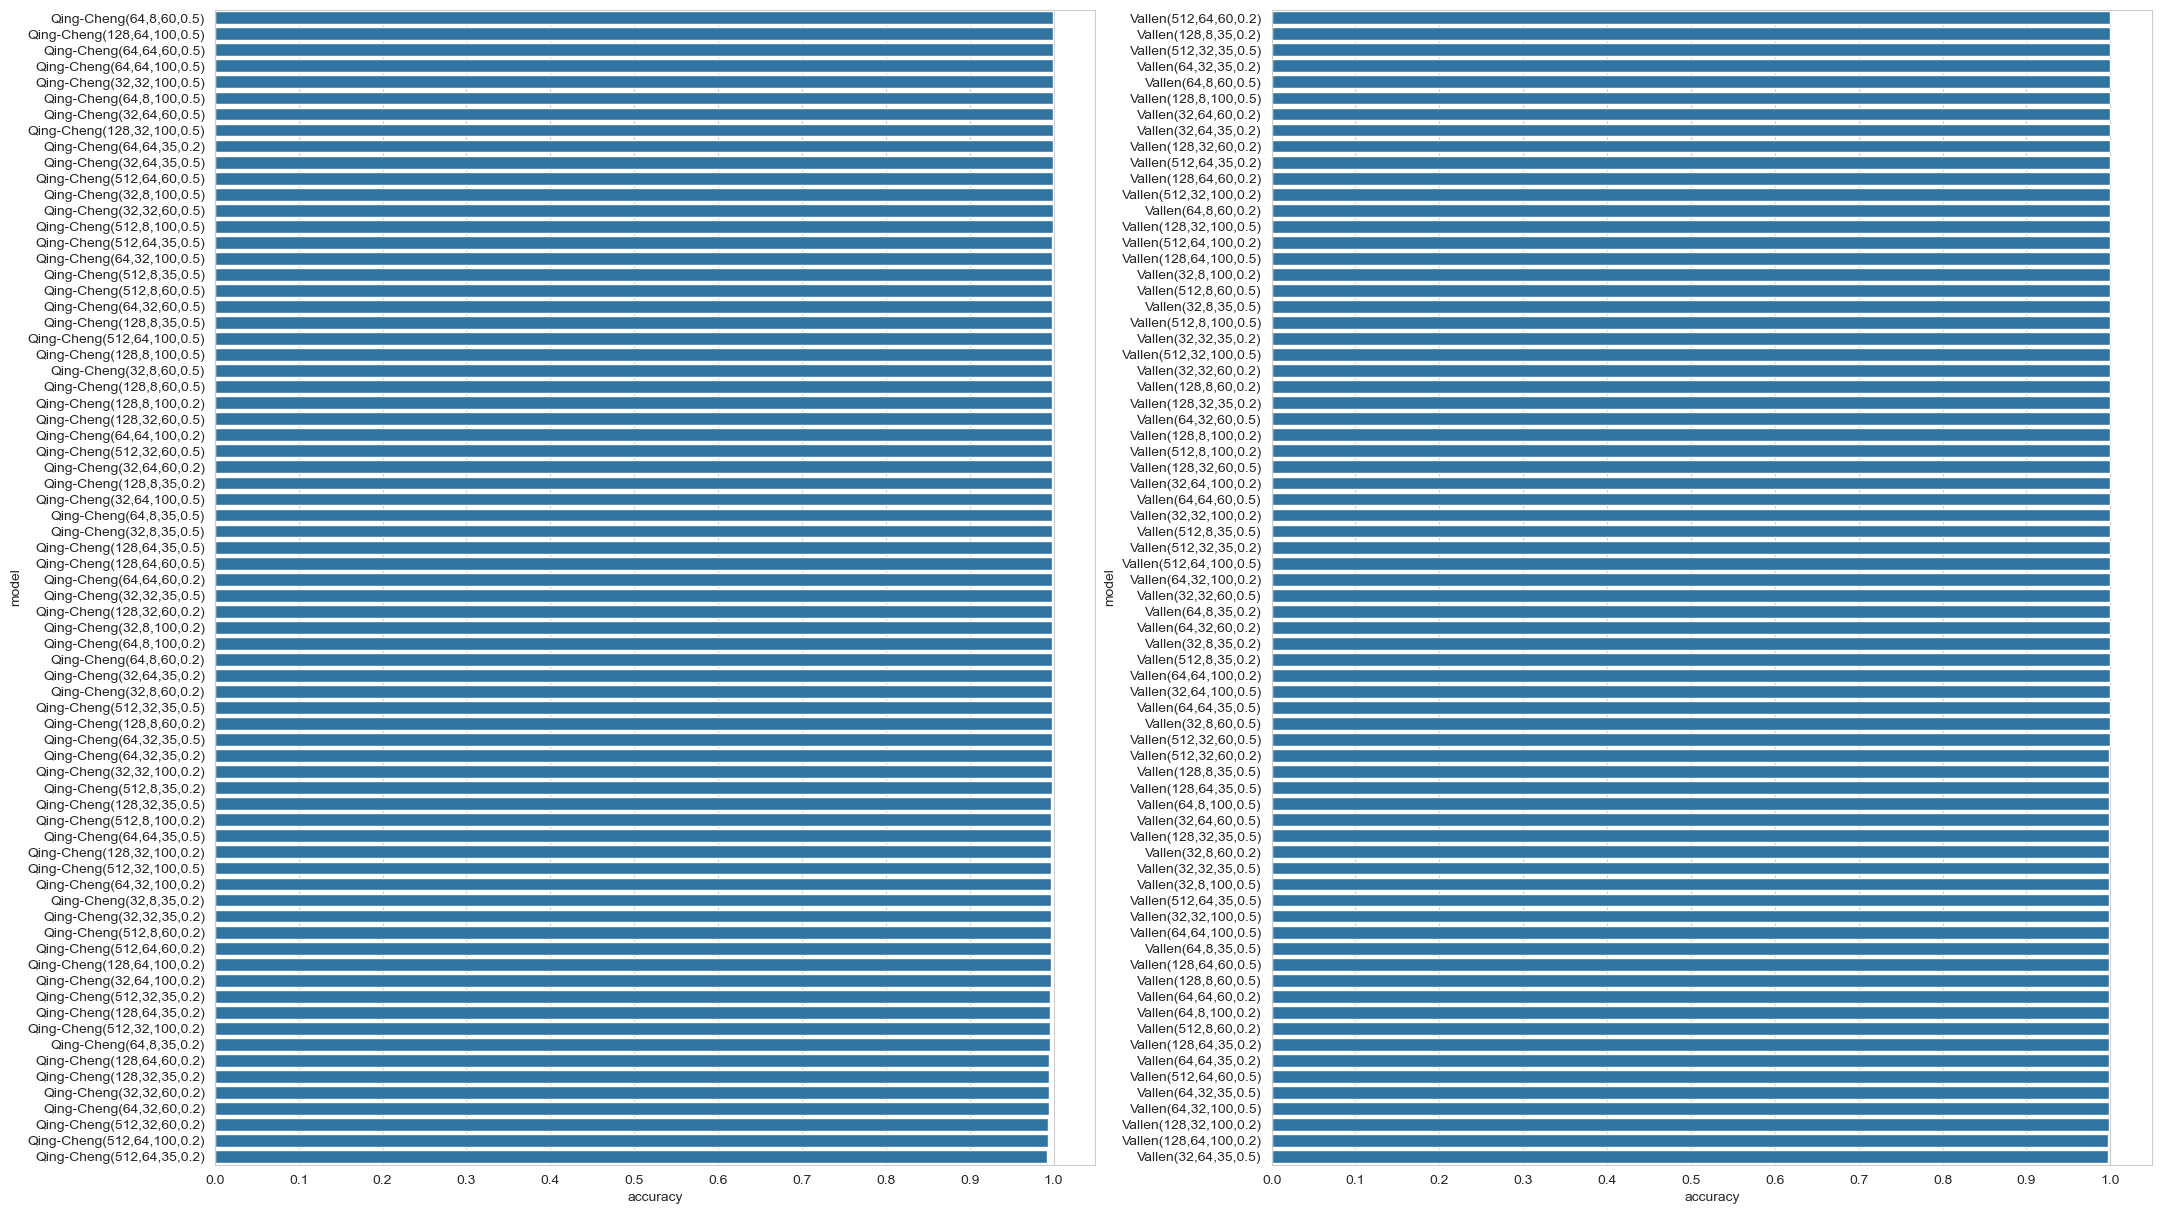

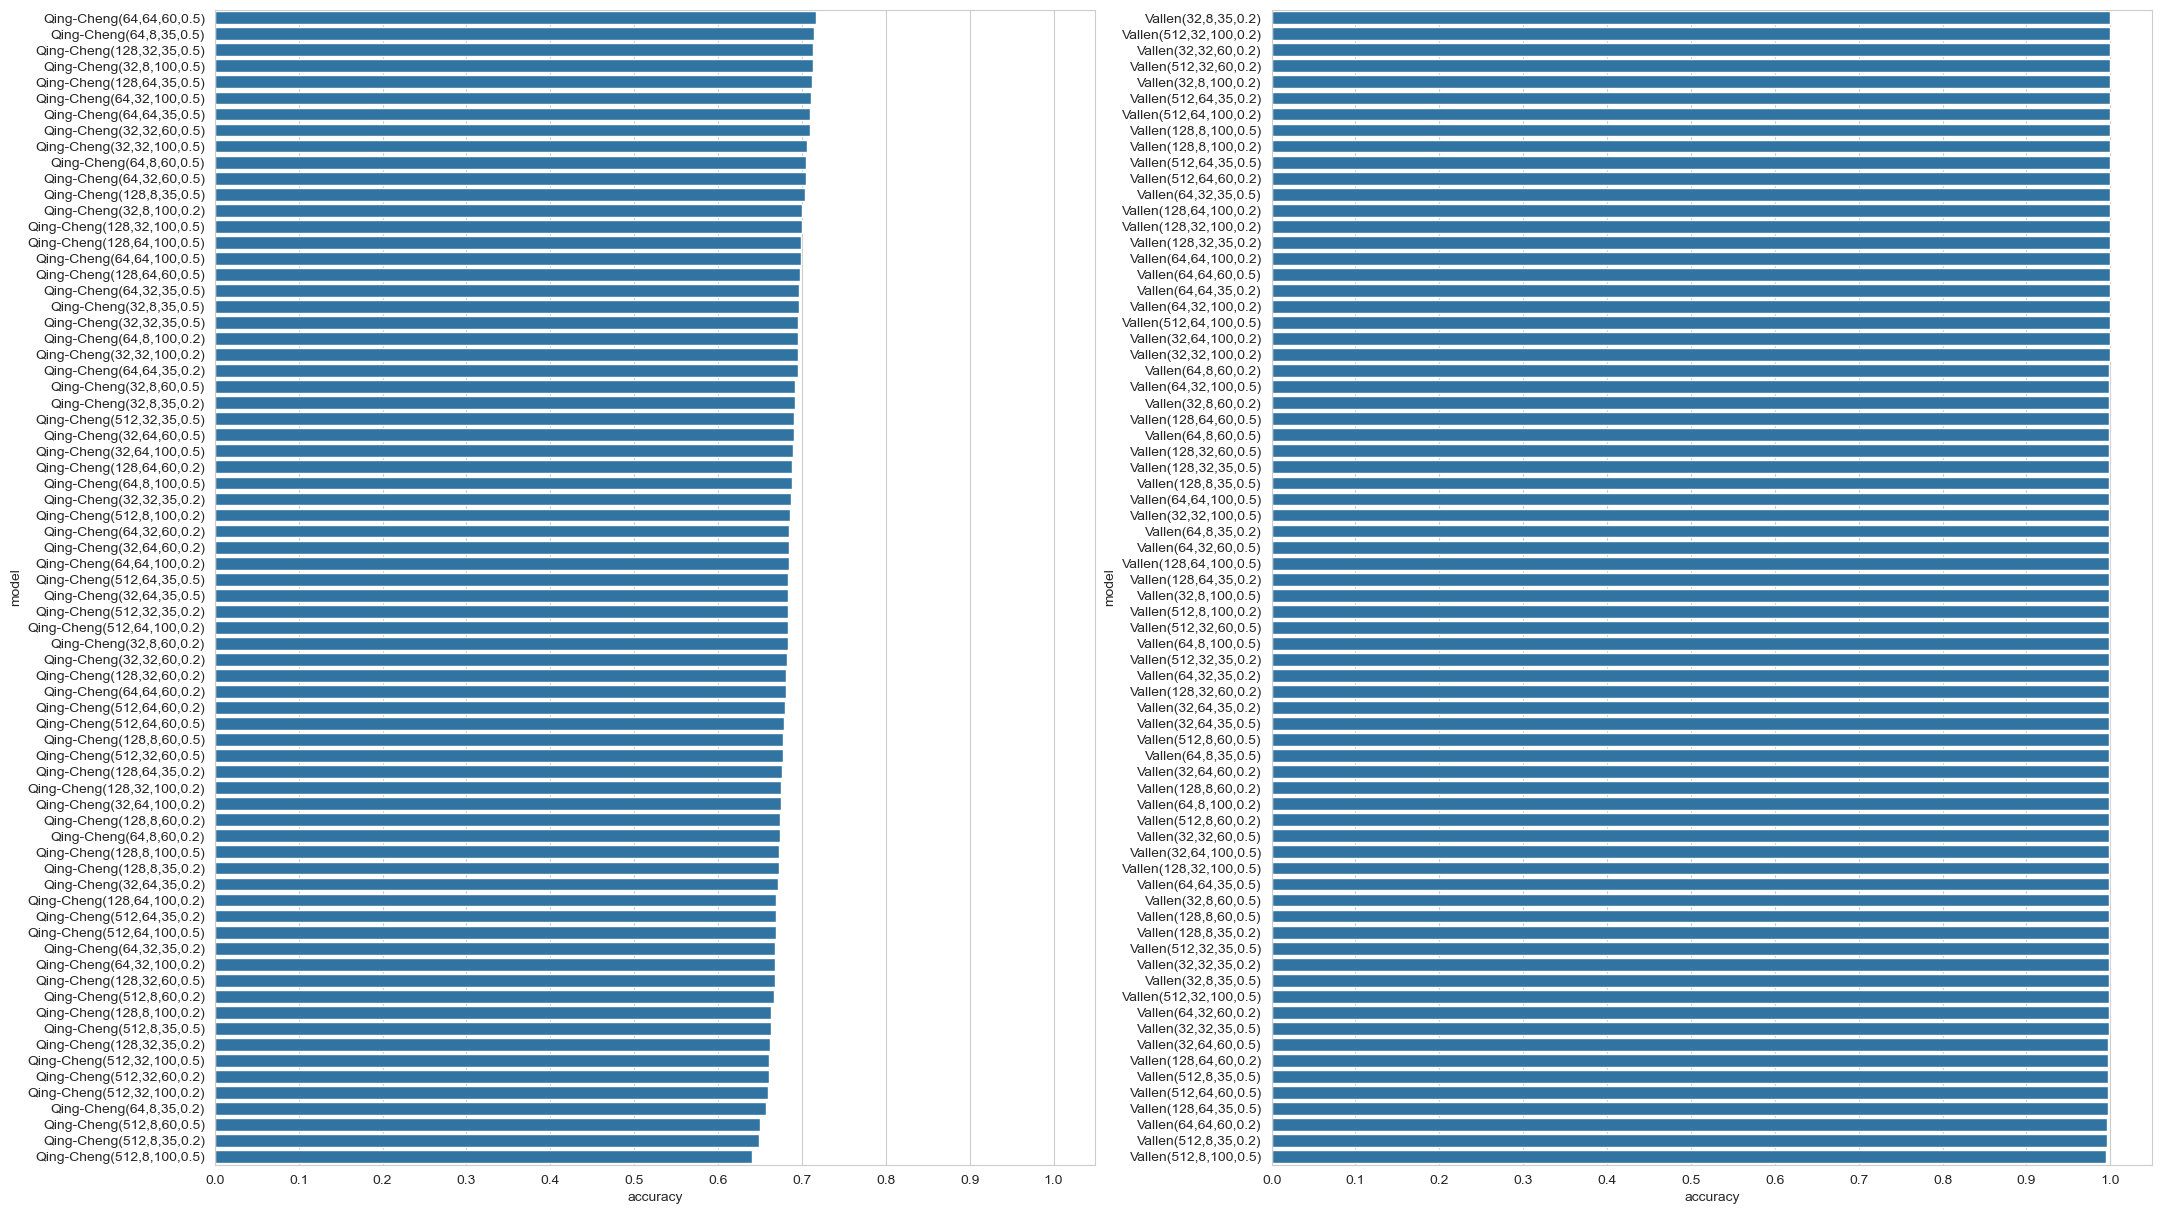

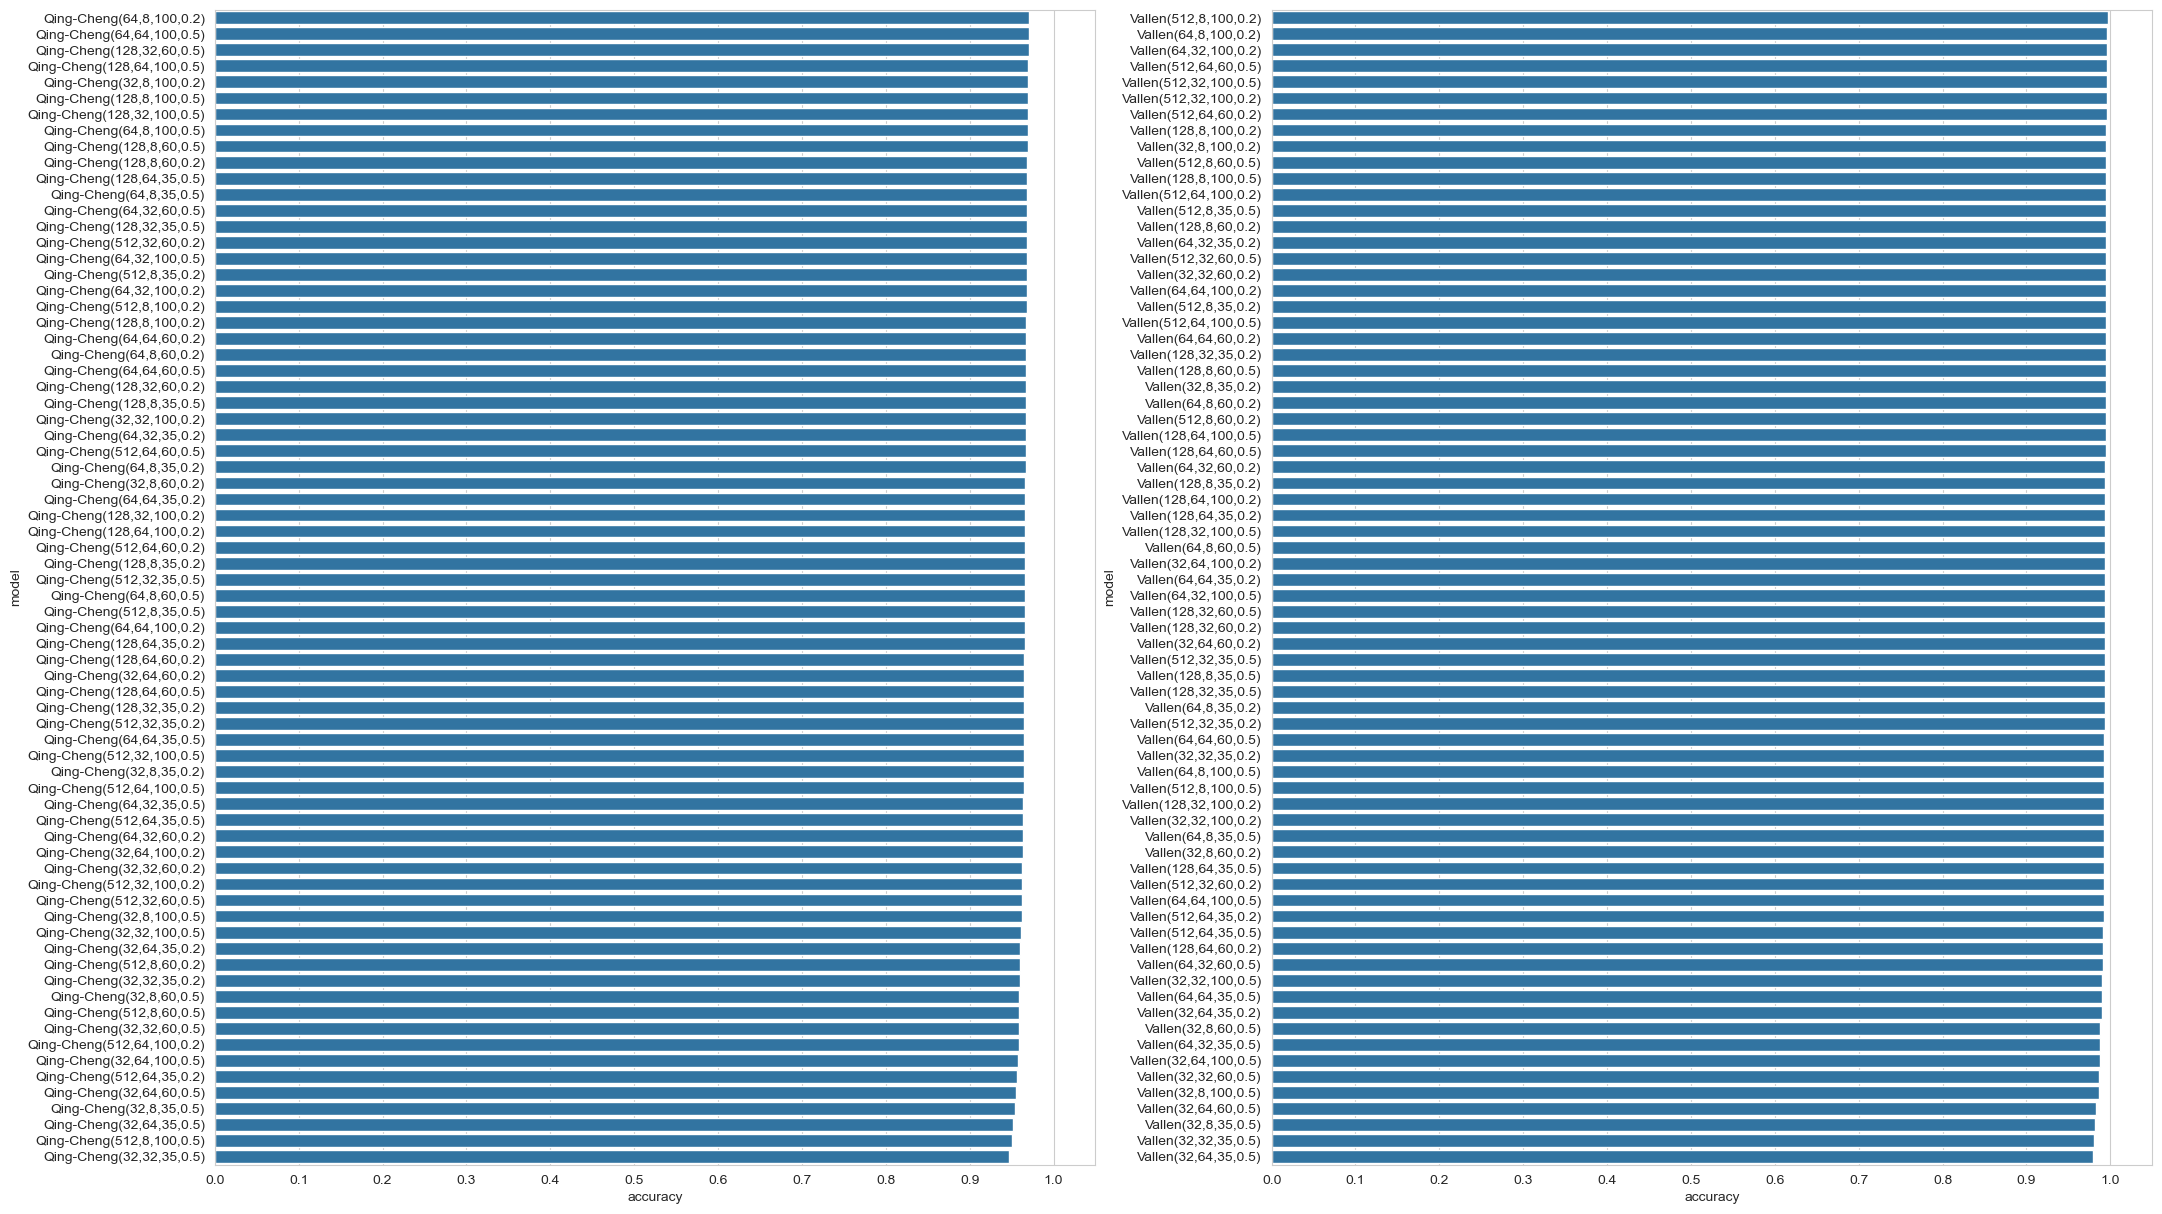

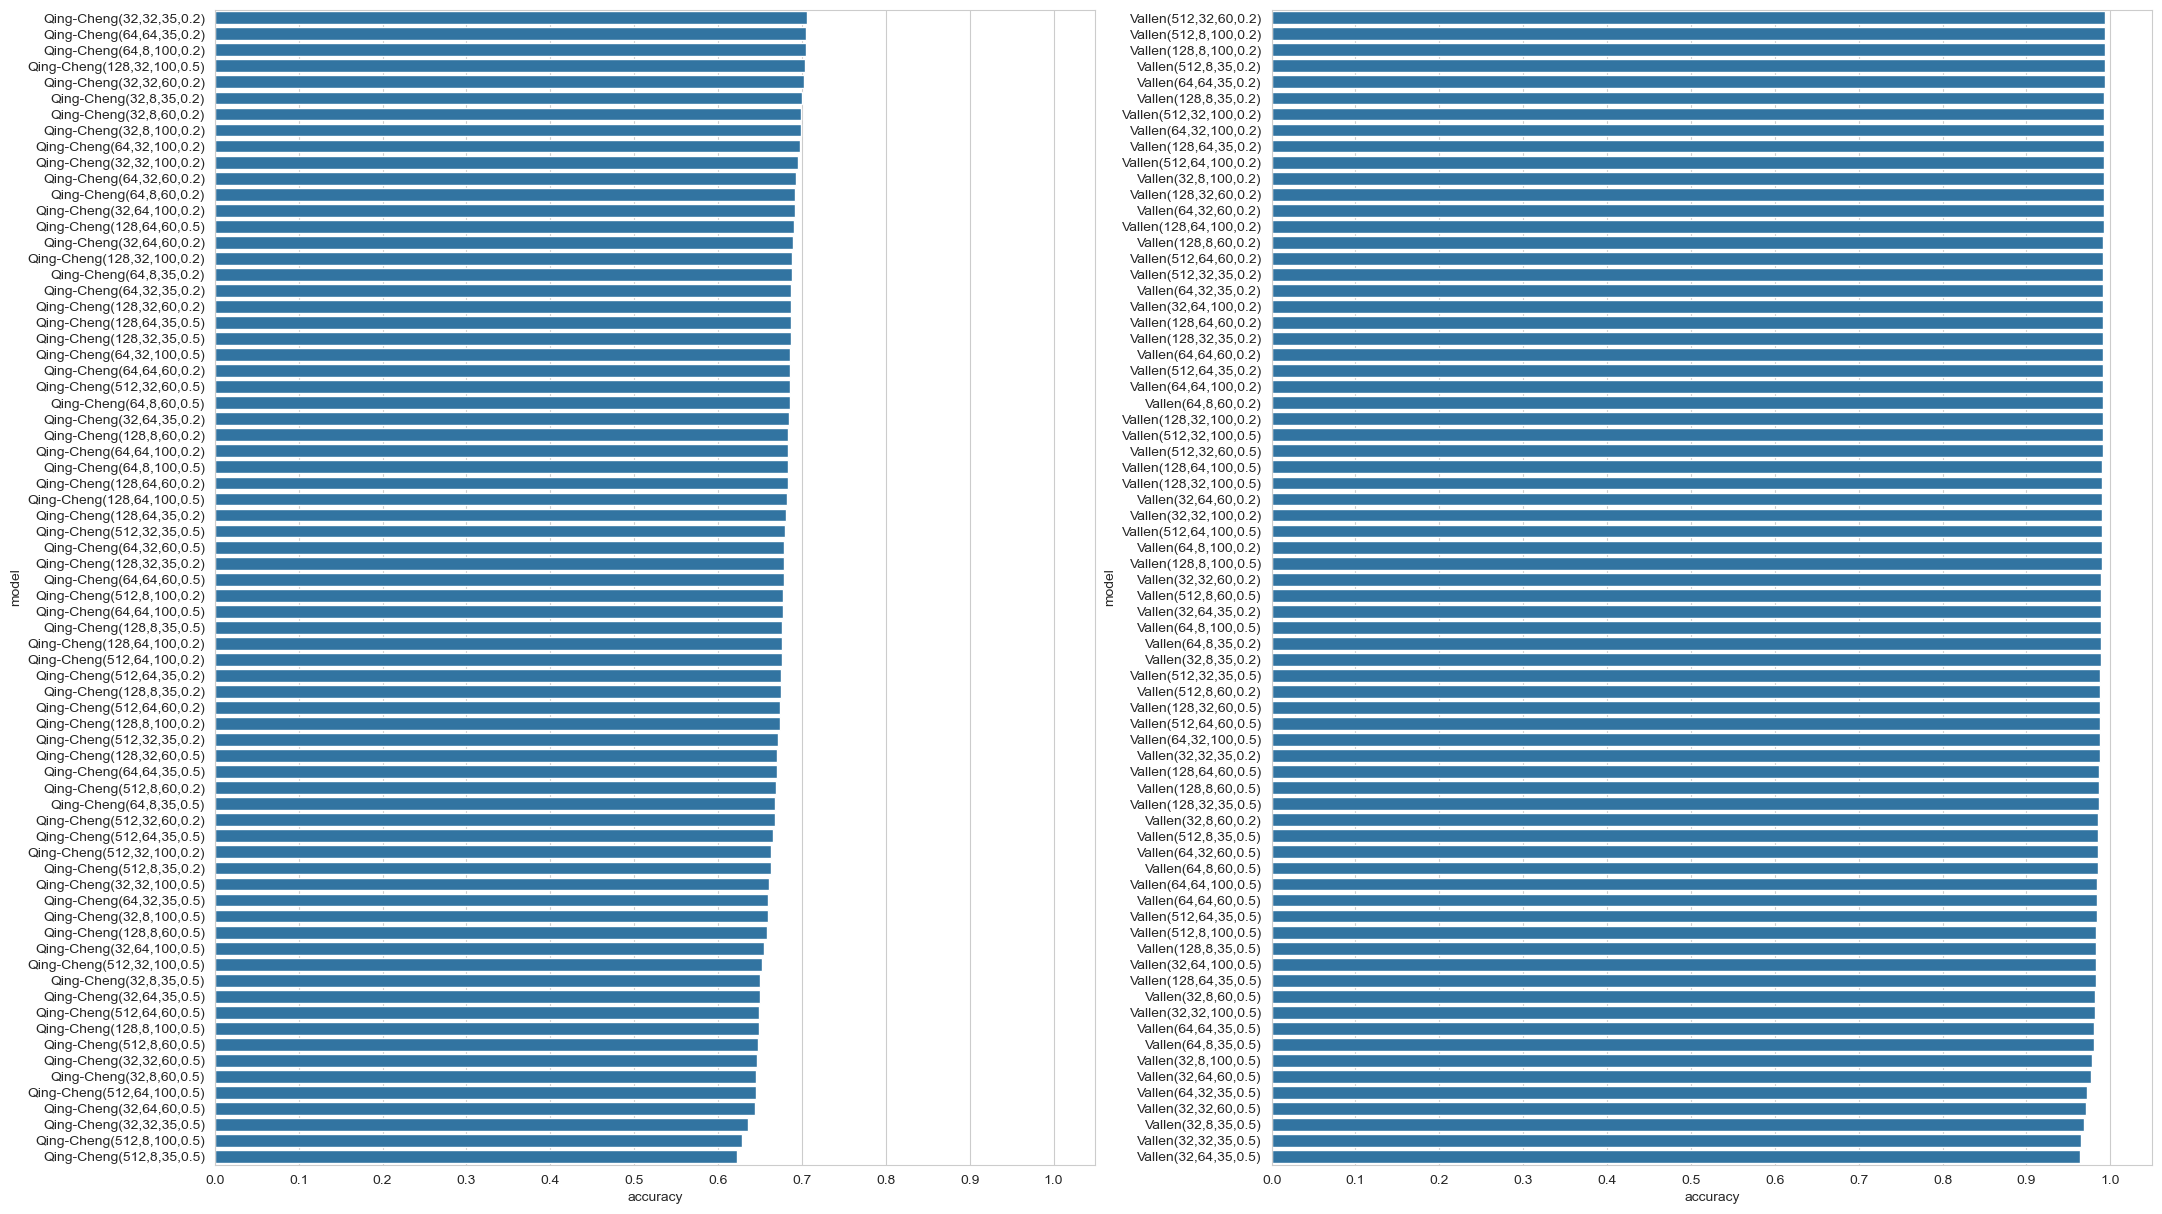

In [75]:
for index in range(len(qing_cheng_models)):
    plot_all_models_by_metric(
        qing_cheng_models[index]['all_results'],
        vallen_models[index]['all_results'],
        'accuracy'
    )

In [102]:
def plot_best_model_by_metric(model_a: pd.DataFrame, model_b: pd.DataFrame, metric: str='accuracy'):
    
    best_models = pd.concat([
        model_a.sort_values(metric, ascending=False).head(1), 
        model_b.sort_values(metric, ascending=False).head(1),
    ])
    
    sns.barplot(y=metric, x='model', data=best_models, hue='model')
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.show()

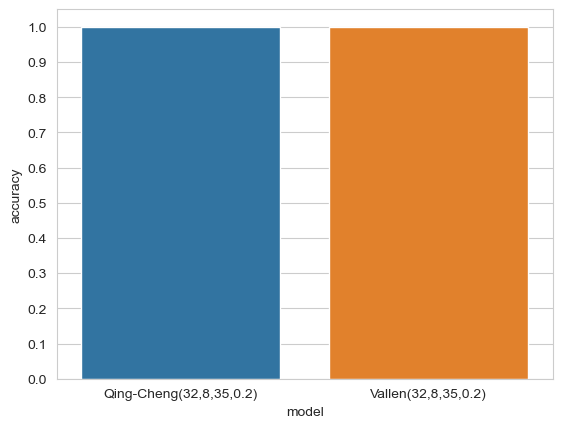

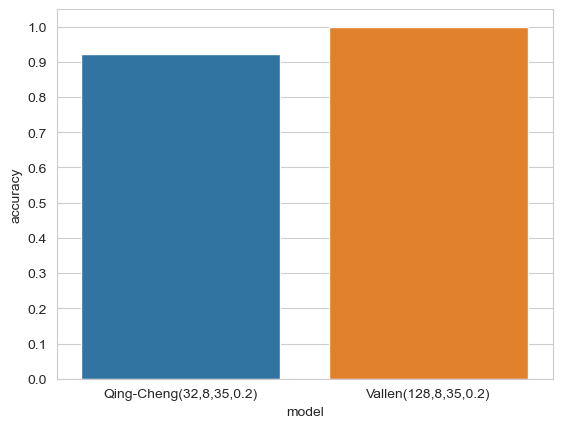

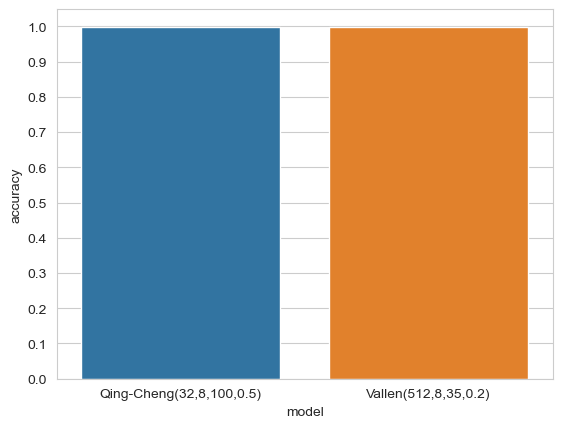

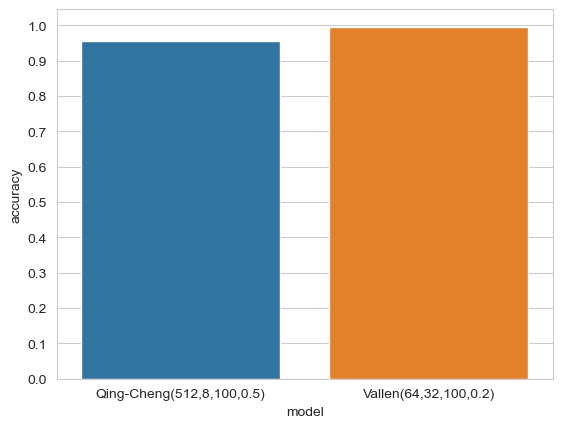

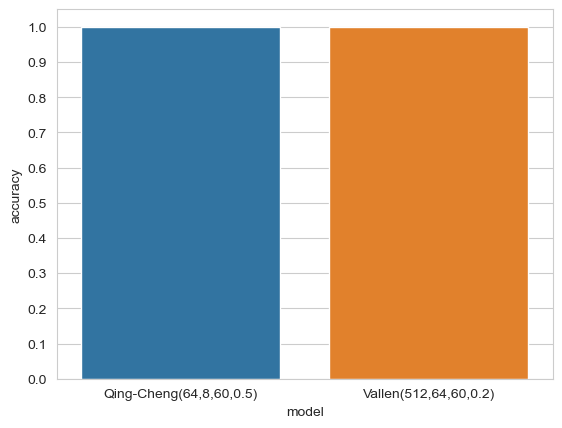

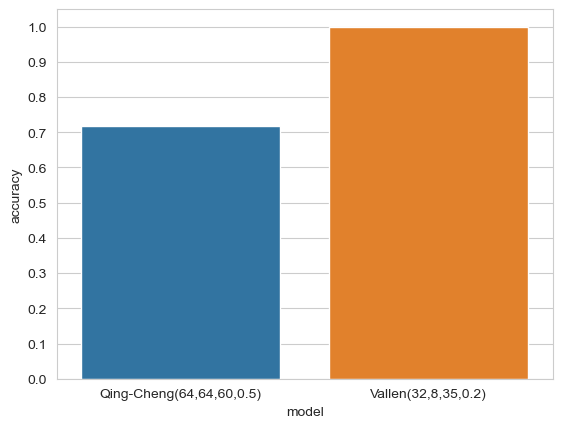

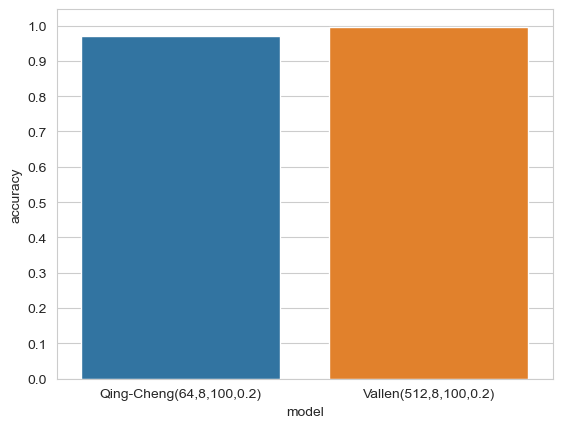

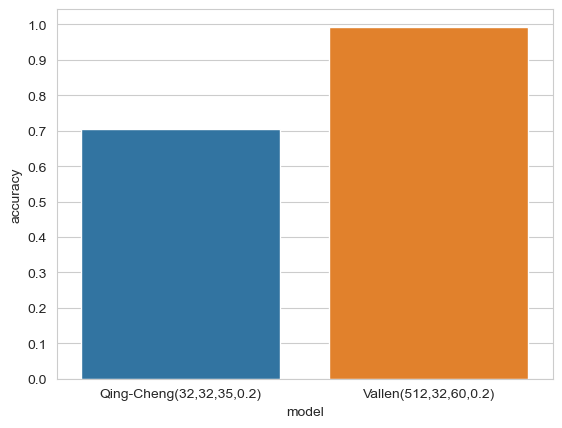

In [103]:
for index in range(len(qing_cheng_models)):
    plot_best_model_by_metric(
        qing_cheng_models[index]['all_results'],
        vallen_models[index]['all_results'],
        'accuracy'
    )